In [266]:
from commonfunctions import *
import skimage as sk 
import numpy as np
import matplotlib as mp
import scipy as sp
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Best angle: 0.0


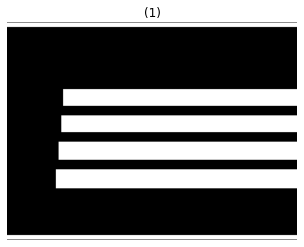

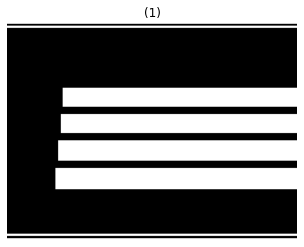

[-1, 2, 8, 12, 145, 186, 203, 244, 261, 305, 322, 368, 467, 471, 477, 481]


interactive(children=(IntSlider(value=10, description='x', max=300), Output()), _dom_classes=('widget-interact…

0
2
4
6
8
10
12
14


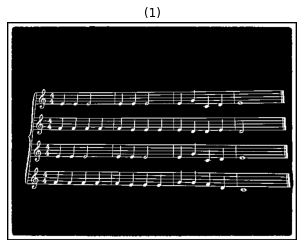

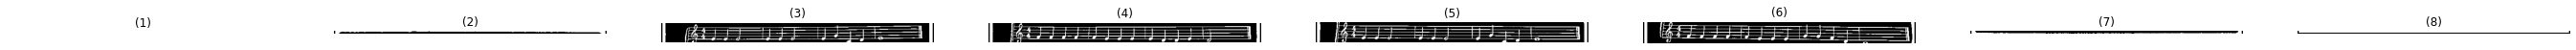

In [424]:
img = sk.io.imread('test3.png',as_gray=True)
img = img.astype(np.float64) / np.max(img) 
img = 255 * img 
img = img.astype(np.uint8)

    
    
    
def binarize(img,block_size = 35):
    t = sk.filters.threshold_local(img, block_size, offset=10)
    img_b = img < t
    return img_b


def deskew(img,delta=1,limit=60):
    def find_score(arr, angle):
        data = sp.ndimage.interpolation.rotate(arr, angle, reshape=False, order=0)
        hist = np.sum(data, axis=1)
        score = np.sum((hist[1:] - hist[:-1]) ** 2)
        return hist, score
    delta = .5
    limit = 30
    angles = np.arange(-limit, limit+delta, delta)
    scores = []
    for angle in angles:
       hist, score = find_score(img, angle)
       scores.append(score)
    best_score = max(scores)
    best_angle = angles[scores.index(best_score)]
    print('Best angle: '+str(best_angle))
    #correct skew
    img_n = sp.ndimage.interpolation.rotate(img, best_angle, reshape=False, order=0)
    return img_n




def line_detection(img):
    
    bounding_boxes = sk.measure.find_contours(img,0.8)
    newImg = np.zeros(img.shape)
    lines = []
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = [ np.min(box[:,1]),np.max(box[:,1]),np.min(box[:,0]),np.max(box[:,0]) ]
        Ymin -= 2
        Ymax += 2
        ar =  (Xmax-Xmin)/(Ymax-Ymin)
        if ( ( ar > 5)):
            rr, cc = sk.draw.rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=newImg.shape)
            rr = rr.astype(int)
            cc = cc.astype(int)
            newImg[rr, cc] = True 
            
            #lines.append(int(Ymin))
            #lines.append(int(Ymax))
            #print("sdsd")
    show_images([newImg])    
    bounding_boxes = sk.measure.find_contours(newImg,0.8)
    newImg = np.zeros(img.shape)
    lines = []
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = [ np.min(box[:,1]),np.max(box[:,1]),np.min(box[:,0]),np.max(box[:,0]) ]
        Ymin -= 2
        Ymax += 2
        ar =  (Xmax-Xmin)/(Ymax-Ymin)
        if ( ( ar > 5)):
            rr, cc = sk.draw.rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=newImg.shape)
            rr = rr.astype(int)
            cc = cc.astype(int)
            newImg[rr, cc] = True 

        lines.append(int(Ymin))
        lines.append(int(Ymax))
            #print("sdsd")
    show_images([newImg])
#     lines = np.sort(lines)
#     print(lines)
#     l = [lines[0]]
#     for i in range(1,len(lines)):
#         if lines[i]-lines[i-1] < 3:
#             continue
#         elif i == len(lines)-1:
#             l.append(lines[i])
#         else:
#             l.append(lines[i-1])
#             l.append(lines[i])
            
            
    return lines
 
def convertToLineSpace(row,lines):
    if row < lines[0]:
        return (-1,-1)
    if row == lines[0]:
        return (0,0)
    for i in range(1,len(lines)):
        if row == lines[i]:
            if i%2 == 0:
                return (5*(i)//2,5*(i)//2)
            else:
                return (5*((i)//2) + 4,5*((i)//2) + 4)
        if row < lines[i] and row > lines[i-1]:
            x = (lines[i]-lines[i-1])/3
            y = int((row-lines[i-1])/x)
            if i%2 == 1:                
                return ((5*((i-1)//2))+y,(5*((i-1)//2))+y+1)
            else:
                return (5*((i-2)//2) + 4,5*((i-2)//2) + 5)
    return (5*len(lines),5*len(lines))


img = binarize(img)
img = deskew(img,0.5)
img_thin = sk.morphology.skeletonize(img == True)


w  = 5
se = np.zeros((1,int(img.shape[1]*0.25)))
se1 = np.ones((3,2*w))
for i in range(se.shape[1]):
    se[0,i] = 1


#img_thin = img_thin > t
for i in range(1):
   img_thin = sk.morphology.dilation(img_thin,se1)
   img_thin = sk.morphology.dilation(img_thin,se1)

#img_thin = sk.morphology.skeletonize(img_thin == True)
img_thin = sk.morphology.closing(img_thin)


#img_lines,lines = line_detection(img_thin)
img_thin = sk.morphology.erosion(img_thin,se,shift_x=False, shift_y=False)
lines = line_detection(img_thin)
print((lines))
def f(x):
    #pass
    global lines
    print(convertToLineSpace(x,lines))
interact(f, x=widgets.IntSlider(min=0, max=300, step=1, value=10));
#img = sk.morphology.skeletonize(img == True)
#se2 = [[0,1,0],[0,1,0],[0,1,0]]
#img = sk.morphology.erosion(img,se2)
#se2 = [[0,1,0],[1,1,1],[0,1,0]]
#img = sk.morphology.dilation(img,se2)

newImgs = []
i = 0
while True:
    print(i)
    r0 = lines[i]
    r1 = lines[i+1]
    r0 = int(r0)
    r1 = int(r1)
    i += 2
    
    newImg = np.array(((r1-r0),img.shape[1]))
    newImg = img[r0-2:r1+2,:]
    newImgs.append(newImg)
    if i >= len(lines):
        break

    
show_images([img])
show_images(newImgs)

In [ ]:
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABUkAAAAyCAYAAABhwVqcAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+WH4yJAAAgAElEQVR4nOydd3gc1bm439ld7a5WK2klWd0qVrOaZcmSJblgsB1sDBgnDpDQgkmhhPCDcAkQchMgJIG0Swg1kAshEGoA2/RgjB0bWy6Si5plVausepdWq23z+0PMuZIlE4rBCZz3eeZ5pJ2yZ2bPfOc7XzuKqqpIJBKJRCKRSCQSiUQikUgkEsmXFd2pboBEIpFIJBKJRCKRSCQSiUQikZxKpJFUIpFIJBKJRCKRSCQSiUQikXypkUZSiUQikUgkEolEIpFIJBKJRPKlRhpJJRKJRCKRSCQSiUQikUgkEsmXGmkklUgkEolEIpFIJBKJRCKRSCRfaqSRVCKRSCQSiUQikUgkEolEIpF8qZFGUslJQVGUuxVFueEjHvs/iqJc/Vm3SSKRSL7ISLkrkUgknx9S5kokEsnnh5S5klOFoqrqqW6D5D8cRVHCgYNAiqqqY4qiGIFngAIgAViuquq2ScdHA3uBZFVVXaegyRKJRPIfzQxytxi4C8gHvMA24P+pqtr+wfFS7kokEsknZAaZmwn8FUj+4JBSJmRu1QfHS5krkUgkn5DjZe5x+24H7gDOVFV1ywefSZkrOWnISFLJyWAD8MZxAmwncCnQcfzBH0zajwDnfS6tk0gkki8eG5gqd0OAR4FEJpxTw8AT2sFS7kokEsmnYgNTZa4dOB8IBWYBm4HntIOlzJVIJJJPxQam2xdQFCWZCdnbPvlzKXMlJxNpJJWcDNYA27V/VFV1qar6B1VVdzIR0TQT24BzPoe2SSQSyReR4+Xum6qqvqiq6pCqqg7gAWDJcedsQ8pdiUQi+SQcL3MHVFVtUidS8hQm9N2U487ZhpS5EolE8kmYInMn8QBwCzBTtOg2pMyVnASkkVRyMpgH1HzMc6qB+Z9BWyQSieTLwL+Su8uAyuM+k3JXIpFIPhkzylxFUQYAJ3A/8KvjdkuZK5FIJJ+MaTJXUZQLAJeqqm+c4BwpcyUnBcOpboDkC4GNidTOj8PwB+dJJBKJ5ONzQrmrKEoO8DNg3XG7pNyVSCSST8aMMldVVZuiKAHA5cCx43ZLmSuRSCSfjCkyV1EUKxOOqFUfco6UuZKTgjSSSk4G/UDgxzwnEBj4DNoikUgkXwZmlLuKoqQAbwLXq6q647jdUu5KJBLJJ+OEuq6qqqOKojwCdCuKkqGqatcHu6TMlUgkkk/G8TL3TuApVVUbP+QcKXMlJwWZbi85GRwG0j7mORnAoc+gLRKJRPJlYJrcVRQlAdgC3KWq6lMznCPlrkQikXwy/pWuqwMsQOykz6TMlUgkkk/G8TJ3JfD/FEXpUBSlA4gDXlAU5ZZJx0iZKzkpSCOp5GTwBnD65A8URTEpimL+4F+joihmRVGUSYeczkS0k0QikUg+PlPkrqIoscBW4EFVVR85wTlS7kokEskn43iZe6aiKHmKougVRQkC/oeJyKfqSedImSuRSCSfjOPtCyuBbCD3g80OXAU8OOkYKXMlJwVlYlFGieSToyjKLOAgkKqq6tgHnzUBCccdOkdV1SZFUaKBfUCSqqozrUwnkUgkkg/heLmrKMrtwB3A6OTjVFW1fnC8lLsSiUTyCZlB5l4A3AXMBsaYkK+3qqp6+IPjpcyVSCSST8hM9oXj9jcB31VVdcsH/0uZKzlpSCOp5KSgKMqvgC5VVf/wEY79PVCvqupDn33LJBKJ5IuJlLsSiUTy+SFlrkQikXx+SJkrOVVII6lEIpFIJBKJRCKRSCQSiUQi+VIja5JKJBKJRCKRSCQSiUQikUgkki810kgqkUgkEolEIpFIJBKJRCKRSL7USCOpRCKRSCQSiUQikUgkEolEIvlyo6rqCTdA/ay20NBQ9eqrr1abm5vVyfT09Kj333+/GhMT85l9t9zkJrf/vO3DZNUXaTvVz1nbEhMT1YGBAfWWW25RFy9erK5ateqUt0lucpPb57udann4RZe5ubm5akdHh3rFFVeob7zxhrpu3boZj7Narae8L8hNbnL77LdTLQ+/aDJXp9OpDz74oHrkyBHVarWq1113nRoRETHjsTExMWpwcPAp7wNyk5vcPr/tRHLqc48kDQkJ4bvf/S7vvfceDzzwAHFxcQD09vbyyCOPcMYZZ3DDDTdgt9s/76ZJJBKJ5AMcDgddXV34+/tTVFRETU3NqW6SRCKRfKFwu914vV58Ph8jIyNs2bJl2jEXXXQRjz76KNHR0aeghRKJRPKfi8lkIi0tjZ07dxIUFMTKlSuxWq1TjlEUhTvuuIOysjKeffZZTCbTKWqtRCL5d+FzNZJ+/etfZ8uWLfzpT38iJycHvV7P4OAgjz/+OCtXruTaa6+loqICr9f7eTZLIpFIJMcRFBREfHw8qqqyd+9ehoaGph2zdOlSnnzySc4666xT0ELJl43CwsJT3QSJ5KQyPDzM+Pg4/v7+9Pf343Q6p+wPCQnhxhtvpKioiG9961unqJUSiUTyn8nZZ5/N0qVL2blzJzqdjmPHjtHQ0DDlmNWrV3PRRRexadMmCgsLmTdv3ilqrUQi+XfB8Fl/gaIoZGVlccMNN3DBBRcQFBQEgKqqvPXWW9x2220cPHjwpH7nj3/8Y8LDw7nxxhtP6nUlX3xiYmKwWCzU1dWd0nYoiiL+VlV1yv+TSUhI4NixYwDExcVht9vx+XwkJiYSHR1NR0cHDQ0NJCQkMGvWLEJCQmhvbycsLAyj0Siu09nZic1mIyoqivDwcI4ePTrl+zWSkpJITExk3rx5lJaWEhYWxsDAgAhNt1gsJCQkUFlZSWJiIjExMfzsZz9jz549J/sRST5jIiIi0Ol0lJSUoCgK/f39U/bn5+dz7733UlBQwOHDh3nrrbdOUUslXxb2799/qpvwidHr9dhsNnp7e2fcb7FY0Ov1DA8Pf6TrWa1WgoKC6O3tZXx8/GQ2VfI5Yrfb6e/vx2634+fnN2W81ev1fO9732NwcJBrrrmGH/7wh6ewpZIvEkuWLEFRFHbv3i0DUyRfaBITE4GJeU5oaCgpKSmkpKTQ1taG0+kkKCiIc845h40bN/LXv/4Vf39/KioqTjjv+rA52Yft+6j7j0dRlBk//6gcf/6nvZ4E1qxZQ3x8PH/6058+8jkJCQksWrSI55577jNsmeRk8pkZSXU6HRkZGfzgBz/gwgsvJDQ0VOzzer38+te/5ne/+920ifenJSEhge9///tYLBb+8pe/cPjw4ZN6fcnJQ6fT4fP5PvJ+nU43bb/H4xHHafu1AUhRFHG+oijodDqxz+fzoSjKlMFKURSuu+46kpOTufzyy/F4PGL/7Nmz6enpIS0tjTlz5tDd3Y1er2dgYICkpKQp3w8TE94FCxbQ1dXF0aNH8Xg8mM1m0tPTaW9vJz09HYCqqiqGh4dZsGCBaKPBYKCgoABVVSktLcXn87Fo0SJ8Ph81NTXieI2nnnqKhQsXYrVaKSsrIyUlhbi4OAICAti/fz92u52oqChsNhs2mw2dTkd5eTnLly+nvb0dmCh3YbVaRYrJ6aefDoDT6RRt0AyhL7/8MrW1tQQGBvLWW2/h8Xim/Xa//OUv+cpXvoJOp+PIkSPSSPofSFJSEjqdDlVVKSoqYufOnVP2X3fddURFRXHVVVexdu1a7r//flwu1ylqreTfET8/P0JCQujq6gIgPDycwMDAKVEcISEhjI+P43A4ZrxGVFQUfn5+wETUXXBwsFDwLRYLs2bNAqCjo4Ph4WFMJpOQVW1tbSxYsAB/f3/GxsYYGxubootoxMXFkZycTEVFBU6nk/z8fDo6OkSJiXnz5mGz2SgpKcHtdpOcnMzs2bPx+XzYbDZycnLYtWsXqqri5+c3LeLV7XZTVVXFkiVL2Lt3L5mZmfh8Ptrb24mNjQUmIrdLSkoYGRkhKioKu91OYmIiHo+H2NhYvF4vdrtd3JvBYOD000+ntLQUi8XCww8/zNjYGOeccw7R0dFYrVbGx8e56aabaG1t/TQ/o+QzJDQ0FKvVis1mY968edx4440kJSWxb98+9uzZw4033sg999yDyWTCZrNx2WWXMXv2bAYGBigvL2fRokVCt1EUhaKiIkwmE8888wyxsbFCh9HpdLS1tQEwODhId3f3jO1ZsGABlZWVjI+Pk5SUxPDw8JRjFy1axO7du2c81+fz0draitFoJCoq6iQ/qQk0fUbTt7q6uggJCREy4nhaW1uZPXv2Ca83eb/D4WB8fJyQkBA8Hg92ux2z2UxERAQDAwMYDAaRpjs2NkZXVxfBwcHYbLZp1+3r62N4eJjo6OgpDmmN/Px8Dh8+jNvtPmG7gBnb7vP56OzsPGH5BafTSWdn5wnb1t/fzxlnnMGZZ57JnXfeecI2fBjHP9cPe86LFy9Gp9PhdDrZv38/RUVF7Nu3D5/Ph5+fH8XFxcDEb3l8WZ/w8HCysrKor6+npaUFi8VCfn7+FH1e05VHRkaIiYlBr9fT0tIi5LaqquzatQufz0dWVpYYA3w+HwkJCbS1teHz+QgKCiI3N5fW1lbq6upQFIW0tDRqa2vFNRYtWiTeNZ1OR0JCAvX19Xg8Hg4fPkxBQQE6nY7W1lZefvnlj+z0knx2aH2vq6sLj8fD6OgoP/jBD+ju7sblchEQEMBpp53G3r17uf/++8nJyeGmm24iPj6e2tpacZ158+aRkZFBSUkJMTExWK1Wenp6GB8fJzU1FYCXX36ZyMhITjvtNAC2b99Oeno6kZGROBwO/v73v1NYWCjmgHq9HlVV8fl82O126uvrKS0tZfHixcKgWlhYyNNPP43dbken02Gz2cjOzkav11NTU0NYWBjHjh1jbGwMr9c7RT/x+XyEhYUxNDTE0aNHiYqKorCwkPLycgCh08CE7K+qqqKgoEC0bWxsjLKyMnw+HwaDAYPBQGFhISMjI8K+0t7ejr+/PzabTcy59+7dS3BwMHFxcZjNZnQ6nZDZdrsdm81GZ2cnLpdLvE+pqamMj4/z7rvvYrFYiImJAaC5uZnw8HCMRiM2m436+npMJhNBQUHi+8LCwkSAT1NTEzExMRgMBlRVpb6+npSUFJxOJ83NzQCkpaVN6R+pqans2bOHrq4uDAaDmP9obTObzZSXlxMdHc3AwADf//73CQ8PZ/fu3RiNRlRVpaenh/b2dqKjowkODhZtCw0NZXBwkBUrVnDVVVfR0dFBeHg4PT096PV6AgMDp/QzjYSEBJqamvB6vRgMBjweDwaDgcTERNrb20lMTGTPnj1CxjudTvr6+kQZy7a2NoaGhvD39yckJESMnUNDQwwPD0+RoZPRnGbH22D0ej0woc9qz0XTxbVrabaCyb+31+ud8rd2/GRDvfa/9n16vX5a2yY78ya/NxqTv/vDbEsfB+XDvAmKonxsV4PW2a699lq++c1vEh4eDkzcnNfrpbKykj/+8Y9s3LiRgYGBT97yGQgJCWHLli3U1tbyxhtvEBoayh/+8AcURcHPz0+0AZimtGhC1M/PD4/HM03hcrvd4gfV6/Wis2jn+nw+PB6PECRahxDFX3U63G43RqMRnU4n2qGq6jQFZXLbJrcZEPeiob002vdPbpvWkQ2GqbZw7RpjY2Pifibfi5+fH1lZWbhcrikRhRpamzWDnk6nIzMzU5yvRQ+3tLTQ398vDOZamxoaGsjKyiInJ4f7778fh8PBihUrADAYDHi9XoxGI7m5uVOMa3l5eeLedTodc+bM4bnnnmPBggWUlZWxYMECsd/tdjN79myampqoqqoCYNmyZWJgqqurY9asWRiNRurq6sRve+aZZxIUFMTPf/5z5s6di16vp7KykuDgYBwOB4sXL6anp0cImLGxMUJCQigrK+OSSy5BURTxfZPR7iMgIIDs7GxKS0vxeDzU1tYSHh5OY2MjTqeT2NhY4uPjqampoa+vD4DLL7+cpUuX8utf/5q6ujqysrKoqanB4/EwMjIifke3283Q0BBhYWHk5+ezb9++aU4IRVEIDg5mZGQEf3//j6TA+fn5TRFWer3+hMJK6xs333wzS5cuZenSpRw4cIC1a9ee0AjyUVFV9cTu1y8Qn0TufhZcdtll/OpXv2LlypX84Q9/oK6ujt27d7N3714UReHvf/87jzzyCOeddx5Lly7lzjvv5NChQ+J8l8tFX18f+fn5pKWlUV1dTUdHB8HBweTm5tLW1kZ9fT1ZWVmEhYWxd+9enE4niYmJjI+P097ejqIoLFy4kJdeegmPx8OcOXOmtFFRFIqLi9mxYwft7e2iPIDWX81mMwkJCbz++usEBQURHh5Oe3s7NptN9P+Ojg4AYmNjiYiIIDExkffffx+fz0doaOiUgXz27NmkpKSwZcsWvF4vJpOJY8eO4fP5prStubmZuLi4KUqEZsDQ5PXu3bvJy8ujsrJSKIqLFy9GURSGh4c5ePCgMICMj4/zwgsvEBMTw+23386LL75Ic3PztAnb4sWLKS8vZ8uWLRQUFLBo0SIMBgMbN27EZrNxxhlnsH37dnbv3k1QUBDf//73gYkJbnR0NHq9ns2bN2M0GgkPDyc/Px+ApqYmEY1x5MgR7HY7Ho+H5ORkqqurcbvd5OfnU1VVhcvlorGxkW9+85u4XC68Xi/x8fHodDoiIiKwWCxs3bpVjI1+fn74+/szMjKCqqocO3ZMOF5iYmIwmUzExcWh1+sZGhqiv79fnJuRkYHT6SQhIYGSkhKGhobE+KlNaFtaWsRkJjc3l/r6ehYuXMju3bupra3lW9/6lpiwa9HwiYmJPProo1x00UUsWbKE2267TUTML1q0iJKSEgDmz59PYGAgJSUlMzqLiouLRbTW8WhG3MmGBS0rACYU3Dlz5uDxeIiLi8Pr9dLS0iLOHRoaIjs7m/b2dsLDw9m3bx9er5ewsDBeeeUV0b7Vq1eL9n4Svgxy91TK3OzsbF599VXOP/987rrrLm644QaioqLo7e3F7XbzxBNPcP/997N27VoSExO57LLLxCRIk3XR0dE88MADBAYG8tOf/pQ9e/YwZ84c4uPjOXToEAMDA4SHh/Od73yH3bt3C5nk8/nYtWuXcBLk5eXx8MMPs2zZMiIjIzl69Cj79u3jsssuo6uri+jo6Cn6TX5+PtXV1eTn56PX66murmb//v2YzWbWrVs3o3Fwz549FBYWfmg01YkYHR1l8+bNREVFMWfOHJKSksREUnufamtryczMJCIiApiQbZONxbNnz6ajo0O8r5ONe++99x6jo6Oce+65eL1eWltbMZvNREZGMjAwQEpKChaLhebmZhwOB52dndTU1LBmzRocDgf79u0jPDycjIwMurq62LZtG+vWrcNkMtHe3o7VaiU2NnbG0jVVVVXMnj1bZNvt3LmTpqYm1qxZQ1hYGAkJCbS0tAjDx9tvv83pp5+OxWIBJowdmrFxbGyMTZs2ERQUxNlnnz3tu3p7e+np6WHlypW88cYb5OTkfKzfobW1FYfDwYIFCxgZGZn2HCsqKujv76eoqOiEfUCbrxQXF3Pw4EFGRkam/EbR0dF4PB5xf7t372bRokU4HA72799PREQE6enpeL1e0adDQ0MJCQkRwQTnnXceg4ODHDhwQHy3NmeaP38+XV1dmEwmmpqaxNylt7eXoKAgEYRRXl7OwoULRdu0zCxt3O3o6BDzpMWLF/Pd736XhIQE9Ho9S5YsYdeuXR/r2YKUuScTg8HA448/zurVq1m1ahUFBQWUlpZOy2D98Y9/THd3N9dddx1XXnkle/fuJSQkRMzDAHJzcykpKeHQoUOsX78ePz8/nE4nHo+HsLAwobuZTCbR7xMTE/nRj37EtddeC0w4T7RgFZ1Ox8KFCxkdHaWiogJA9K2HH36Yhx9+mO7ubux2u9ANsrOzOXr0KDabjeTkZGBCdhQWFnLzzTfz6KOPcuzYMZKSkoRc3L9/vwjEcbvdHDhwgLy8PBITE1mwYAE//elPgYnslHnz5hEbG0tzczPp6emEhoZy8OBBxsfHWb9+PcnJyfzzn/+c8uzee+89/P39+c53vkNlZSVlZWWEh4djNptFVK7NZhPz75CQECE/NUe6ZutITEyko6NDODq093poaIjk5GSam5sZHBwkMzOTuro6cnNzycjIYGRkhMHBQfr6+hgcHAQm9KmsrCx6e3vp6OjAZDIRHh6OoiiMj4/T399PRkYGo6OjDA4O0tbWhs1mIzw8nLGxMVavXk11dTV2u104na1WKw6Hg2XLltHZ2UlnZ6cY+wYGBhgZGWHhwoU0NjaSkpKCyWTCbDZTVlbG3LlzSUlJ4e233yYoKIixsTFh7H7//fen9dv8/HwqKipYv349O3bs4KWXXuIb3/gGKSkpwjnY1taG2WwWc2+DwSDsXWNjY0RHR9PY2IjZbMZsNpOamkp5eTkdHR3k5eVhNpuF3UizF+3ZsweHw0FBQQF79+7Fz8+P4OBgUlJSUFWVl156iYCAAGw2m8h+SUhIIDQ0lP3794vfNCkpCaPRSE1NDbGxsXg8HioqKkSgQX9/P2NjYyiKQn5+Pg0NDdjtdoxGI9nZ2VgsFmG/8ng8HDp0SNietLnJ/v37CQgIwOFw0NHRwbFjx0hISOCBBx6gs7PzI8uJE8nck2oktVqtfO973+O2224T0R0+n4+hoSFKS0u577772LFjx6c2jvr7+xMUFCSUD1VV2b17N2FhYbz00ks89thjDAwMsHDhQn75y1+ybNkyUlJS6Ozs5NixY8yaNYuCggJaWlro7OwkOTmZ0NBQ3nnnHebOnUtPT4/o3Kqq4nQ6OXjwoDDyxMfHEx0dTU1NDWlpacJL0NjYSEdHB5mZmQQEBIiOa7fbiYiIoK6ujuLiYiIiIqitrRWG2UOHDok6VHq9nvz8fMxmMx6PR3h/XC4XZrOZ0NBQYXAEaGxsJCIigv7+fhoaGoiLiyM8PFx4T2DC++V0OjEajbjdbiwWC+np6bz22mv09vYSGxtLe3s7mZmZhIaGMmfOHOGhGRkZoby8HLvdTmtrK0VFRQwPD7Nz5076+/tZsmQJHo+H8fFxAgICSE9PR6fTMTQ0RENDAx6PB5vNhtfrpb29nebmZmJiYoiLi2NwcFAYIyIiIlAUhcTERAYGBkhNTaW5uZmOjg6hnPT19REcHCyUk7GxMVJSUggKCqK2tpampibi4uIYGRmhurqaqKgozGaz8HYZDAahcGl4vV5GR0eFIfs3v/kNLpeLn/zkJ2IiMdmQaLVahVJ4PIGBgdOO1zAajeJlHxsbQ6/XT1Ee9Xo9ZrMZmJgIKIqCxWLB4/Ewb9487rjjDr7xjW/g8/nE+drxBoOBrKws+vr6cDgcFBYW8sorr7Bo0SIyMjKwWCzCyG80GvH5fJSWlpKamioEnM/nm2Isdzgc4v6zs7MJDQ3F4XDg7+9PZGQkzc3NwlARExODx+Ohu7sbh8PBCy+8wN13301TUxNf+cpXqK2t5dxzz5VG0o/Iv4uR9A9/+APXX389X/nKV2hvb8disdDd3S0irB9++GF++9vf8txzz/H888/zt7/9bcr5Ho+H/Px8/vSnP/HMM8/wxz/+EZiYWJeXlxMZGUlqair5+fnCiJOWlsaVV17JFVdcgcViYdWqVfT29rJlyxbR1zRZaTabmT17tlBWnn/+ec455xwOHjxIUVGRaEdJSQnNzc0EBgYSHBzM/v37eeyxx3j22Wdpb28XjoSwsDDCwsJwu90MDAxQXFyMv78/u3fvZsmSJeTk5PDqq6/S3t7O0NAQK1euZGRkhH/84x+oqkpERASjo6PMnTuXyMhIMTHTJkkFBQXk5ORw/vnn85e//IX29nZGR0cpKysjNjaWZcuW0djYOM2gpTnhNOVBG1u1saq3t5dZs2aRnZ1NY2Mjx44dm+bIGBgYID8/n66uLrq7u+nt7SU4OFhERY2MjJCenk5ra6swNGryBSaiNLXIsJ6eHtasWcMbb7xBeHg41dXVBAcHExERQW9vLxkZGeh0Orq7u2lvb2dwcHDKmOXz+YRhWlVVHA6HaIeqqrS3twvZo0VAhIaGCsejFv0OEBkZSWdnJ1FRUeKak5np8yVLllBeXs7Q0NC/TDtLTk7mmmuu4aabbpq2T/N8TzaCT96n3etk5+pkp+nkc4/PktCYM2eOMMJ/VHQ6Hbt27RKRGdJI+q85lTL3q1/9Kk899RTf+ta3sNlsPPHEE1P2b9iwgfz8fFavXs0111zDu+++O63fXnDBBbzwwgt0dHQwd+7cGY1wx3PBBRdQVVVFZWXlR27rNddcw8aNG6e8g/+KDRs28M9//nNaDcCTgclkYseOHaxdu3bGCdHixYsJCAjgnXfeEZ+Fh4fT19d3whTz888/H6/XKxwNk4mOjhZRnJNZtWoVo6Oj0ya6xxMUFITH4/nYupDVauXee+/l+9///oxRnwsWLODCCy/k1ltv/cjX3LBhAxkZGdxyyy0fqy0awcHBuFwu4aQ/mVxyySUUFBT8W5aX+LAx44wzzuCqq64SxumlS5f+yz4xE1Lmnlz++7//G6PRyO23387mzZt56KGH+Oc//4nFYmFsbAyz2czf//53FixYwNGjR1m/fj39/f2YzWYxF7JYLFx//fXceuutNDc3s3btWrq7u8WczGAwCCMkTNgpdDodhYWFfO973+OrX/3qlPmnxWJBURScTidutxu3241er8flcpGfn8/GjRu56KKLpmVwaWjZMRohISFs3bpV3OOHoQVDBQcH89BDD3HllVdOMQafiJUrV5KZmcn9998/bZ+fnx8PPPAAv/jFL4Qz90T4+/sLB/o999zDu+++y/bt20VUr6YraXNpi8WC0+nEYrEwMjIiMh23b99OcHAwgYGBjI+P43Q6hR6myVltXu52u7n00kvZuHEjLpdLPPfAwMApMtlsNmM0GoWN6emnn8bpdIpnBhN66jPPPMP//M//UFpaCkzM+zW5EBgYyPDw8LR72bBhA3fccQe5ubnCDhYYGJjhC9cAACAASURBVIiqqjPaFaxWK2NjY9x8880A3H333QQEBGA0Gk84fmmBZpoDNSAgQAQgaAbb45k9ezaxsbEUFBRgNBrZsWOHiB4GyMjIwGq1cuDAAbxeL7m5uWJ+M3/+fBGxW1ZWhtlsZt68efT391NfXy+M89rv0tvbK3QBk8lETk4OOp2Ozs5OmpqaxPc1NjZitVqFYbampoaBgQHmzZuH0Wiks7OT2NhY0cbh4WEeeOABLBYLfX19rFmz5mPpKSeSuScl3T4wMJCzzz6b66+/noKCgimRjs899xx33XUXMBGB8mnR6/U89NBDIkpR+6GqqqoIDQ2lvr6eqqoqfvvb37Ju3Tqqq6vR6XT8+c9/BhAKU2RkJAsXLqSjo2OapzMzM5OXXnpJRAKNjIxQW1s7rVOOj48zf/586urqpkSRbNmyhbS0NBEddPjwYUwmE1lZWZSWlhIVFSXSnjRD6cDAAB0dHaiqyubNm0lMTKSrq4vk5GTsdjvt7e2kpqYSFRXF/v37xfdpnWd0dFRERtrtdgDS09Opr6/nhhtu4P777yc6Opru7m7xMiqKwg033MBvfvMbxsbGyMvLo6amZtp9Thbio6OjeL1eXn75ZcbHx4XxQgun1tK13W43Ho+HkJAQbr/9dm666aYZI20mExwcjNfrFd447TMNbUAxGo0MDQ2h1+tFes2WLVtQFIXGxkZhxHG73Vx55ZX88pe/BGBoaGhaeLler2fhwoUcPnxYRGH29PQQEhLC0NAQubm5pKSkkJaWxvDwML29vfT19QkPniYU/fz8aGlp4dixY6SmphIaGsrw8DBerxez2czcuXMxm824XC4qKytJTU3FZrNRXl5Ob28vgYGBXHjhhRgMBg4dOkRjYyMxMTE0NzfT1dVFfHw8zz//PMeOHWP37t2EhISQnJzMsWPHRApGYGAgRUVFtLe3M3fuXFJTU0UEc3d3N16vl6ioKMbHxxkbGxPvoyagtbQkn8/H4cOHxb298sorZGZmcuTIEbKzs/9lCQun08kvfvELkbo0Ojp60kLfJZ8fBw4coLW1lfHxcTo6OqYoUYqiUFpaysMPP8zmzZv51a9+NW2/Xq/n6quvFp7w0tJSFEXhwIEDYr8Wfa+laRQUFDB//nxefvllxsbGeOSRR4D/i3afKQ3kd7/7HYWFhWzcuJGnn356SgreTAQGBuL1etm6dSvbtm0T15tstAJ4+OGHxd9RUVH09fVx0003iWMeffTRaW3T6/XExsayZMkSnn322Sn7y8rKyM3NJT09nVtuuWWK8ezAgQNs3rwZVVWnOCsAli9fTnR0tKjHabfb8Xq9U54jIIy1RqORW265hbfeeouysjLxnBsbG6ccr/1emvH5yiuvZP369VOyHCanwLS3twtvc2NjIwaDQaRsdXV1CY/64sWLufjii7nwwgvFuFBeXi4ieGZi8mI1RqOR9PR0FEXB4/GIiASA6upqLBYLaWlpwhkXGRmJTqcjKioKl8tFR0cHq1evRq/X09bWRnFxMV1dXTgcDmJjY/nVr37F/fffT0VFBWvXrqWurg6Xy4XL5cJgMIjnc+TIERISEpg/fz7f/OY3xXPRjtmwYQMNDQ1s3boVr9crokb9/PzIzc3F4XBQWVlJSUkJer2e73znO1RUVNDW1sYFF1xAQ0MDLS0tNDc3c+GFF+Lv7y8iK7R00LCwsCk1TLVxQRtn7XY7fX19QgnVDOeRkZEi7VRLD5T8e6LX60VUeGNjo/hcp9Oxfv16rrvuOnJzc9m1axeVlZUUFBSIyJJ//OMfXHbZZdx5553AxOQzJydHTMCys7NRFIXa2lrcbrdwYnu9Xr7+9a/jcrm47777RNkiLXtGk2WqqlJZWUlDQwMpKSlcfPHFtLe3U1dXR3JyMn5+fhw9ehSfz0dkZCTR0dHU1tYyNjZGbGwsOp2On/3sZ/z0pz9l/vz5tLS0kJqaSm1tLVarlX379hEXF0dnZydnnXWWSGuenBGkyZ+MjAyhq+zfv5/Y2FgMBgN1dXUi8kSbrI2OjtLb20tKSoqIrsnOzgYmZE1kZOSUCJWUlBT8/f2pqanh5ptv5ne/+x25ubm4XC7q6+ux2WzMnj2btrY2BgYGsNlsJCUl0dvbi9fr5Wtf+xrx8fHccsstHDlyhMjISKKiolBVFbPZTFJSEv39/ZSXl+NyuUQ0a3x8PJGRkQBTjCGpqakivTI5OZmQkBBMJhPz58+noqJCRGSNjIwwNDTE3XffzbZt24TzPCUlRcj69vZ2EVU7MDCAw+EgIiKCRYsWMWvWLKKioggICGB8fByv10tAQMCUNNa+vj6R7TQ6OirappV/Sk9PF/I5IiKCiIgImpqa6OnpEf1Zi/g8duwYq1atEgEqXV1dzJ07F/i/8To7O5sbbriBkpISES2n9QGDwUB6ejp1dXV0dXXhcrmIjIzE6/WK0ifx8fEi2nlyf+7p6cFgMBAcHEx1dTWBgYEiO0KL0g8ODqatrQ2Px0N0dPSUYB+dToderyclJYXu7m72799PXFyciNqqqanBarUyd+5cRkdHT4JkkJwMzGYzl1xyCfv370ev19PY2EhsbCxZWVlkZWVRW1vLN77xDRYvXkxlZSV/+ctfWLRoER0dHSQlJYm50OrVq/nJT36CoigkJSWJ6MvQ0FBee+01goKCMBgMvP/++8yaNYuVK1eyYMECrFYrnZ2dnHHGGVx66aUMDQ1x5MgRzj77bOLi4qivr6ejo4POzk6CgoJ4//33Wbx4McHBwSxZsoT58+eLewkICMDPzw+DwcCCBQt45513xBw5MDCQzMxMLrroIpxOJ4ODg1gsFpGd5HQ6hd5gMpmwWq20tLQQEhLCZZddJvTA0dFRAgMDGRoaEu9kVVUVY2NjbNiwgaamJr72ta8xMjJCXl4e5eXlIkN29erVlJaWioCZJUuWUFFRgaqqHDhwQLzPdXV19PT0kJ2dTXh4OAUFBTNmrWol21wul5h3hoWF8fWvf11kJe3duxe9Xi8M0H5+fvj5+eF2u/Hz8xMRlMHBwVx//fVs27ZNzO2joqKorKyc0UC5YsUKiouLef3112ecS1gsFlasWCEMfiEhIeTl5aEoCocOHeKMM86YMlcODQ0lLCyMlpYWUlJSppSd8vPzIy8vj8HBwWnlRmBCfno8HhISEsRn2u+j/f6a887f31/og5o+GhgYiN1ux+Vy4fF4pt1PVVUVJSUlxMbGEhISwqZNm1BVlaCgIJEJNTIyQlBQEENDQ7S0tKAoCkFBQWzbtk3Iu6CgIFGqxM/PD71ez6ZNm6bdD0zoKkajkU2bNuHz+TAajeI31HTqoKAgEfEdEBCAwWDgrbfemvH30EofOJ1OrrjiCpFl9Wn5VEbSgIAAVq1aJVbenGwc3blzJ48//jh79+49KcZRjdTUVJKTk/nb3/7GunXruO+++8RgrqXirVu3jq1bt/L+++8THBzMrl27RC2LVatWkZqaKiL0tBo32mAIE1Ez4+PjHDp0CL1ez5133snjjz8uFvOxWq2YzWZ6e3upra3FZDIxa9YshoeHMRqNnHXWWQQGBgrDrJa2cejQIcLCwtizZ48QVoqiEBsby2OPPcb69eux2Ww0NTWJKFAtfTUqKoqBgQEaGhoYGRkR3hGtNpkW5dPV1TUl4sdgMBAdHU1aWhodHR243W6xX1EUVq9eza5duzh27JhIJZxp0aLY2FjmzJlDZmYmFouF+vp6kpOThfckIiKC4uJidu/eTXl5OV6vl/POO4+6ujpWrVrFddddR3h4OHv27GFwcJC8vLwp19eUSj8/P0ZGRoTAzMzMxOFwYLfbWbp0qUiLeeqppzCZTJx22mlER0fjdDqJj4/Hz8+P0dFR9u3bxyWXXEJ+fj7XXnutqHl33nnn0dbWRmNjo/AAFRUVERAQQFVVFQMDA8TExLBo0SKOHDnC4OCgmOA3NDQwNjaGz+cTyp+qqoSEhODz+RgcHMTtdgtjUE1NDS6Xi4iICKKiomhsbBTG32eeeYYXX3yRv//976L/TjbKaEqfz+cjOjqadevWcfXVV9PT0zNFQGjHab/n5s2bxWT+0y5yMmvWLGFw0upjVVRUiJo4RqOR3t5e4aEaHR0VhpfBwUGuvPJK4uPjee+996at2Cv590dLoZw7d64YIDs6OnA6nWzYsIGbb74ZRVF48cUXmTt3LtnZ2aiqSkVFBVlZWVx//fXExsYSHBzMtddeS1lZmUgJnz17NnPmzGHPnj0cOXJETGy+9rWvERwczO9//3sRZQmIdLcDBw5gsViYM2eO6Fenn346IyMjXHDBBaIWnqIovP/++9hsNqxW65SawfPnzychIYGsrCyio6PFJNbhcNDX1yfqqmpKljbBPnToEBs2bBD7tEloYWEhHo+H559/nm9+85sEBQXhcrnQ6/X4+fmxZMkSkR6dmZlJUVERN998s6jLlJOTIyaQ7e3t4l6181esWMHw8DB2u52MjAwuv/xy8Sw1r63mXHO73cyZM4dLL72UnJwcXC4XGRkZ7Nmzh4aGBubMmSNSMisqKsjOzsbpdPLOO++Qnp7OM888A0woMO+//z7nnHMOQ0NDvPLKK6iqSk5OjojOUhSFkpISMjIyeOGFF/B6vaxevVqUSikpKaG8vJy0tDRGR0dFLS63243P5xOZFjExMcTExFBdXc3u3bvJysoSskeLNK2vr2fWrFmMjIwQHh6O1Wqlq6uLpKQk7Ha7cDoajUZRT1BRFEZHRzEajTgcDrq7uzEajWRmZnL66afT09NDa2srhYWFtLa2ivbl5ORgtVoJCwsjIiICt9stjNJaX0xMTOStt97iuuuuo7u7myeeeIIDBw6I/rB161ZhQNbYt28fHo8Hp9MpotS0fvHmm28CE1kGk52NxzM0NITVahV9eXR0dMqiTSEhITidTm699VYCAgK44oorPoUEkHweFBUV0dvbywMPPCDSBGHCeDp//nwWLFjAP//5T26//XaGhoZoamri8ccfFw4mq9VKZWWlMNgEBgZSXV0NTNTajYiIICYmRhgLfT4fR44c4bTTTqO2tpalS5dSU1Mjyifl5uZy5MgRcnNzxWdWq5WQkBBsNhtnnXUWb775JitWrBBOFC0CqKioiMOHDxMfH8+yZcuE03vFihX09PRgtVpZtGgR8+bNw8/Pj4KCAhRF4ejRo5x22mlClk12PLW2ttLc3Czq4xkMBq655hoxCUtMTOSOO+4Q9QYB8Z6tWbOGTZs2UVxczOrVq4Hp9egPHjzI5ZdfLlIgh4aGRFu08cThcNDf38/w8LAoyxUcHExjYyP19fWcccYZjIyMsGbNGhITE5k/f74Yp7RacMPDw+Tl5YkyLVrWT3NzMz6fb0rKu+YkKS0tZcWKFaJM0/r16zn99NOx2WyMj49z5MgRMZ9Zv34927dvR6fTicj+1NRURkdHMZvNjI6Osn//flEfOTAwkPj4eK644gph6NMmq1rGEUwEg/j7+zM0NITL5ZpS01lLHdb6lZZmmpOTI+r4NTQ0kJubKzLTtJqHDocDh8OBzWbD4XBw+PBhfD4f8fHxDA4OMn/+fBGVabfbaWhoIDMzk5SUFLKzs3E4HPh8Pvz9/amurqa/v5/i4mJmzZqFxWLBbrdjMBjIy8ujqqoKVVWnpP9nZmaKrLvS0lLOO+88jEYjw8PDomSEVmuwoaGB5ORkioqKUFWVxsZGoqKiMJlMKIpCd3c3CQkJ6HQ6rFarqHsoOfVoKcS7du0SfVWbm5eWlrJ8+XIuuOACxsfHue+++/jLX/4izt2+fbv4W4s+/MlPfoLJZGLr1q08+eSTwgivzcs0x/DLL7+MwWDg5z//OW+++Sa7du1i7969qKqKx+MR5x6P1+ulr6+Pb3zjGzzzzDNTnKTx8fEEBQURGBjI4cOHhd6m0+kIDQ1l/fr1IqOgurpaRMIqikJXV5fIyHE4HDQ0NLBw4ULOOussHnvsMUwmE2effTZNTU2iPNbkICCn00lUVBRVVVUYjUa6u7vZunUrHo+HyMhIUSpEc8p3dHRQWloqyodceeWVmEwmSktLSUtLY926dXR2dpKZmYndbuf666/H4/EInV/LONPpdOTk5Ijv0MamzMxMRkZGmDt3LklJSSiKwo4dOxgfH2fFihW0tLRQWlpKXFwc8fHxzJkzh/DwcObNm8fSpUvp7Oykvb2diy++mICAAFRVZe/evVx44YV0dnayZMkSvF4v119/vQgEczqdIvIzNDSUgoKCKZkYxcXF6PV6li1bJhyHWnkVvV7PhRdeiKIofPvb36a7u1s4yABsNhvLly8X8/ejR4+KWuDx8fEkJibicDgwGAxkZGTw/PPP43a7ycjIICkpifr6et59911R415RFM4++2xGRkbw8/Pj2Wefpbi4WNh/bDYber2e7u5uVFWlq6uL7OxsUlJSGBsbw2azkZmZKRYGbW5uZv78+cKuEB0dLeaGx44dQ1EUoqKiRE1yq9VKW1ubyNZWVZXe3l4xdmpOVG0dgPT0dEwmE4GBgXR0dAjdQ7N5xMXFYbVaqa+vx+Vyoaoqr7/+OiaTidzcXPR6PUlJSaIvnEiH/rh8IiOp2WzmzDPP5Ec/+hGLFy+e8qKPjIywefNmfv/734vOfrJQFIUnn3ySvXv3EhgYSFJSEuvXr6ekpAS73c4VV1zB4sWLKS0t5fzzz0dRJhbi2bJlCxaLBZ/Px29+8xt0Oh1Go5Fly5axdetW1qxZQ1pamqjrpkXthIaG4vV6WbBgAYODg1RVVdHe3s4555yD0WgUk/je3l6WL19OZ2cndrudq6++Gp/PR3JyMnv27KGgoIBDhw5RUFBAcnIyZWVlIsR779695ObmkpWVxd13301nZyf79u3j7LPPpq+vT3hEzz33XEJCQmhoaBAvV319PXa7HZPJxPnnn4/JZOLdd9/FaDSKmhutra1kZmZy1113UVlZyYEDB0QnUhSFWbNmsXr1apxOJ9XV1cyaNYuEhAQcDodYbGPWrFkEBwfT1NTEqlWrUFVVeEQ0S/3o6Cg9PT3CUA0TUcRaGmV1dTVvvvmmMDZO9pprnrmWlhaioqJmVDD8/f159dVX6e3tFSkOMBEmXl5ezmuvvTYlQtTn84kaGrfeequIivrtb38rIsa0a7zwwgvi7/feew+v1ztt9bkPi8T5yU9+IhZZmExkZCQWiwWXy0VJSYlYXV5rX15enohC7ujowN/fn7CwMPr7+xkdHSU8PByTyUR6erqILtJqkcFEvT5NKdOiSefNm0dxcTGqqlJSUkJAQADz589n7969IqV+4cKFwNQU2t7eXmHIVBRFpBOPjY3hcrkIDAyksrISm81GYGAggYGBxMTE0NDQgM/nw+v10tTURHl5OQcOHCAjI4OioiLMZjPLly8Xkw/JfwaKomA0Gunp6eGll15idHQUPz8/XC4XMTEx/PCHP8TtdnPPPffw4IMPAgiPu1ZPs7e3l5tuuoni4mKMRiNtbW2Ul5fT39+PxWIRC4Jpg355ebno82+88YZwYgBs27ZN1KEZGhqitraWQ4cO4fP5qKysFFGFubm5mEwm9u/fj8lkEnV6tRpNAJWVlXR1dfH666/jdrspKCgQtd+MRqPw/paWlpKfn09ycjJdXV3YbDYGBgZEuQqLxUJCQgJvvfUWBw8eJC0tjW3btnHaaadx7Ngxtm3bRmJiIgaDQUT7RURE0NPTw7vvvktfXx95eXlUV1dPcSRu2bIFmPCYz507l9DQULZv305ZWRk1NTVs3LgRmEgFDw8P5xe/+MWUyBWz2czSpUv585//THl5uZCLDocDk8kkxuvh4WHhbCsqKuKrX/0qN954o/A0j46OigmD5gx7/vnnsVqt/Nd//RebNm3iwIEDWK1WhoeH0ev1PP3003z7299m7969orwCTBiVHQ4HTz/9tJC/WqSav78/l1xyCVFRUdx7771YrVbRZkVRREkUbVzTJq7XX389ZrOZH/zgByJVSjMcnyidtaCggIsvvpibbrppxvTc4734y5cvZ9myZbz11luMjIyIyDX4P+//rl27qKurE1FsM0UCACJFys/Pj56eHpEK5XQ6GR0dxWQy4XQ6RZqU0WgUBlDNIOR0OoXCfXwGjNfrpa2tjfHxcUwmE+Xl5Z9JKqzk5KIoCkeOHCEkJEToTn5+fvz85z9n6dKl3Hvvvbz88stCZ3I4HPT09IhyUA888AB//etf2bZtG2FhYbS3t9Pb24vZbBbG9+MJCAigs7OTiy++WDgYNJ566qkZz9HpdKxcuZKHH36YmpqaGSNENL3p8OHDvPbaa8TFxbFw4UJuu+028b6d6PonijiZiXfffVfU/nv77be56667hKN/MmFhYdjtdnbu3HnCtFWAt99+W0QTXXPNNTz77LPs2rVL6Fdut/uE75JmdPjjH/8o7u21114DEDXVJqdiTubDyjdpbNy4EYPBwLnnnsurr746Y5rlDTfcgNVq/Vj1Lx988EGWL1/O3Xff/ZHPCQwM5LzzzuOZZ56Z8X60NFOYMPJrxuCvfe1rLF26lNtvv/1f3u+bb75JU1MThYWF/PrXv56278N4/fXXp302ub99mlWld+7cyZNPPvmhx/j7+7Nu3ToOHTrE2rVrP/F3SU4uPp+P/v5+EbxSVFQknAIvvvgizz33HGVlZVOMTE6nk97eXqKjo2lvb6eiooLu7m7Wr18vSk14vV5R4xIm5mR2u53u7m7Gx8dxuVykpqbS1tbGu+++S3BwsMj2nOn90b4rMTGRffv2iYWNNGYKONOMVppu/OqrrwpnkdvtnjIvPb7kiVZPVXNYaCWzTlQiYsuWLfT29vL8889P2xcQEMDSpUt58sknhf41eY2CySWIABGJuH79el577TX27ds3Zf/kebmWOaY5zgMDA1m2bBlXXXXVlOeo6Zavvvqq+Fv7bZYtW8bixYt555132Lx5syiFNNlh5vP5eOGFF1BVlXPPPZc1a9bwox/9SLRj8vU2bdrEPffcM+VZvfDCC1OeidZmjd7eXi655BJuvvlmUeZvMpPLLk3OvjzzzDPZs2cPt91225TnoTFTCRBFUcjJyeFvf/ubeLaT5WNCQgImk0msyZKamsratWvZsWMH9957LykpKQBC39UyDNrb29HpdCJbYfL9tbe3M2vWLPz9/fF4PPT29qIoiljboaGhgYCAAGF3aGlpEXOXlJQU6uvriY6OJjQ0lKioKN577z2x1oNmZ9CMnz6fTwTT7dixg/DwcBYtWoTX6yUiImJGB8Qn4WMbSXNycvjjH//IaaedNq2O1vbt27nppps+dQTbiViwYAFz587lhRdeICsri0ceeYRXX30VmFiJWVPEHnroIZFyrqUhaZx55pn88Ic/5NJLLxXKy/ED3+QOZzKZKCoq4u677xZRcm+//bZ4WbTjJg/eKSkp9Pf38+CDD6KqKv/7v/875eWajKqqXHrppSxatIjvfve7QgF6+eWXp3T6J554Ytr5k/f/6U9/mvYZTBjqFi9ezHe+851p+0JDQ0lISOCuu+6a4q06/llo19Veut7eXl599dUp+2pqaqaluSqKQlhYGKWlpVRWVopoRIPBQHx8PGNjY4yOjlJYWEh3dzezZs0SA8Rkuru7CQ8Pp7u7G7fbTWJioviOOXPmoNfrKS8vF2laWvH4efPmibSH8fFx+vr6pqy4qqWhayvoqaqK1WolNDSUq666ipiYGBRFoaGhgTVr1tDS0kJ8fDxvvvkmhYWFhIeHMzw8zBlnnMEll1zC448/Ll7M2NhYkpOTaW1tJS4uju3btxMVFYW/vz/79u0jJSWFpUuXMm/ePFwuF21tbQQEBBAREUFnZyfvvPMOKSkpFBcXi9XrzjzzTLGCvcViEYtlVVdXi0GxtLRUeOoiIyNRVZXHHntsSrSRNmi2tLQIo2tXVxejo6PinR4YGOCVV14Rg6e2kmtoaCjBwcH09PSI6GtFUYSBXHuOTU1NLFy4kKKiIiGMJf85WCwWMjIycLlcxMfH09PTI96fv/3tb1RUVPCLX/yChQsX4vP5GB0dJSgoCH9/f2H0eemll6ipqeGNN95g3759og7k22+/DUwMujDRX5qbm7FYLAwMDLBz5042bdokohU9Hg9er5fQ0NApCqBGR0cHmzdvpqSkhJdeeglARMJMPlYblwoLC3G5XAwODtLf3y+MBO+9996056A5bP77v/+bbdu2iYl2QEAA/f392O123G638LRqil9gYCDd3d20trZOmZxbLBYiIiKEsvvKK6+gKAr+/v7iGC0Cp66ujkOHDnHttddSWlqK2+2mv79fLKS2b98+USd48lisRRM2NDQwMDAgjIoGg0FEFXm9XjweD62trQQEBAhnzcDAgDDWaf9r9bVhwkCjRdE6nU5xHX9/f3w+nyiH0tXVRU9PD0ajUdzbTPWgtcU75s2bx+jo6BTP+mRmz56N1WqloaFBGAe7u7s577zzCAkJITs7W6S3NjY2Ckeg0+nE39+fBQsWCOdTVVUV6enpYoXW0NBQcnJyxCI2RqORrKwssdCiXq/n1ltvFcbj6upqEhISGB8fJzQ0lEsvvVREv2qLcE1eUVpbxCEuLo6enh4SP1iYwGAwcPbZZ/PXv/6V4uJiUlJSKCsrE+NYUlISVVVVlJWVcd555xEeHs7Bgwc5fPgwVquV5ORkdDqdiJSy2+28//77vPLKK8ydO5e0tDThZf9XtVclp468vDyOHj3KT3/6UxoaGvjxj3/MzTffzH/9139RU1PDc889x7XXXovH46G0tBRVVcnNzeXiiy/mz3/+MwMDA1xxxRXcd999OJ1O1q5dy5lnnklKSgpPPvmkWJxBm7harVZR2/h73/seDodDlIbSnLitra3U1NQQHx9PSkoKO3bsQFEUzj33XCorK0W0fkZGhojO0kp9aAtYOJ1OvvrVrxIZGSkczV3nPQAAIABJREFUpqqqMj4+LsoxaRGGg4ODjI6Okp6ezsGDB0lMTKSurk5Emmo4HA5aWlowGo1ibEpLS6OwsJC0tDShf2mOtPT0dCoqKigoKCAyMnJKGmJeXh6HDh0iJyeH5557TkTxNjY2EhYWxtKlSwkJCeHw4cM4nU4yMzOJjY1lbGwMk8lEQUEB3d3dbNy4EbPZzBVXXEF/fz8jIyOkpKQIp4Xb7aa+vp7MzEwURcHhcJCZmSkczz6fj4MHD06p3ZaXl0dnZyetra243W7sdjv33HOPiNr9/+x9d3iT9d7+naRJV5qmTdI2bdKkey+6KVAoo4KsMhSUKUfAAThQVDyi+CJ6FFGPHFBfXlRA3IgDUGSV1UUpbWlLB90z3UnbdOX5/dHf93MaKKBn6TmH+7pyXZS0yZMnz/Mdn889mIS0vr4ehYWFKC8vx9atW5Geng4LCwvykDcajbCwsEB0dDQMBgMuX76Mnp4es3NiZ2dHAXTMnqm/v5+87Pz8/CCVSmFra4uqqio8//zzkEqluHbtGvh8PoKCgsivrrq6GnV1dRg1ahQGBwdpzT5nzhwzFRs7FwAoRAkYsowxGo3w9vbGqFGjiBwiFotJzcAyH1j4qJeXF6RSKS5fvgx7e3v4+vqC4zjk5eXBaDQiJCQE3d3dKC4uhlarhcFgoIIZj8eDs7MzDh8+jIiICAoLYYUpdj2zUCkebyhgpKenh+aGS5cuoaenB4WFhXBzc4NcLqdgsr/Vk/QO/rFgyhxbW1vI5XJMmDABly5dwquvvoq9e/fi4MGDeP3117Fq1SrY2dnh3LlzOHbsGCmeysrKkJ6ejpCQEDQ0NKCoqAjt7e145plnoFarYWtrC6VSCTs7O+Tk5KC+vp6aKgqFAoGBgXj//fdhMpmgVqtRW1trpkhUqVQUbPTkk09Cq9XCxcUFzz33HFxdXaHVapGWlgaOG/JGDQ8PR0NDA3788UfodDqEh4eTPHnixImIiYmByWTCtWvX0N/fT7ZCbA5hY6G7uztiY2Px5z//GdXV1RS4NNxD/tKlS9T46Ovrw+LFi9Hc3HxDKHB4eDjc3NyQmJhIa0RgiNVfWVkJGxsbKJVKtLS04NKlS3B1dYWLiwscHBwQExODwcFBODg4oK+vDy0tLdScGhwchF6vh0qlQmNjI1pbW+Hp6Yn09HQIBALah8fExCArKwsdHR0QiUSIj4+n8wyAQoTYGl0mk9GxW1lZQSwWE5lIqVRCq9XCw8MDWq0WUqkUxcXF1OxirHF3d3dKqs/OzqbPzdaWLJSoo6MDzc3NKCwsJJ9N1ixipD32u8BQ2Bfz56yuriabGmCopsOYrxzHoaOjg/JrgCHWKbPwiYmJwWeffXaD3R0rWLJ/A0OSe1dXVwQHB2NgYOCGgnxnZye9x8DAwA0B1ezYR6olDZe99/T0EEmAvT9rXrC94HCiXFFR0W0t1Fj2UUtLC5qampCYmGgWiPr34BcVSdnNtHLlSixbtoyKSuzgiouLsWPHDnz66adobm7+hxzYSHBwcEBaWhreffddLF++HJcuXSIfol27duHIkSPo6OjAokWL8OWXX8LBwYEYkK6urhCJRMjJyUFeXh5KSkpw/PhxeHt7g8/nQy6XQ6FQ0CB6/vx5KJVKWFpaIiAgACkpKWhtbaXCWXV1tdnGtKSkBH5+fqitrYVWq8XAwABmzZpFXnuVlZXkrcHg4+NDFOzy8nKkpKRgcHAQ5eXlVD1niz4eb8hjk3mjyuVy2lCyG4B5GAFDN55EIkFMTAzi4uKQkJBAAwG7KENCQpCUlITIyEjweDy4urpScElvby9MJhMWLFiA2tpabNmyBfHx8eTt0t3djTFjxsDX1xfffPMNxGIx+V2eOnUKDQ0NmDVrFuLi4hAWFoa8vDySewoEAmg0GgphUSgUKCkpgV6vR1tbGzw9Pc3SW3NycqgjPTAwAIlEQh60Go0GAQEBaGtrQ01NDSwsLODs7Izm5mYEBgbCZDIhJSUFlZWVqK2thUKhQFVVFZycnHDp0iWEhYXB2dkZDQ0NqKioAI835If6448/mlkwsORB1l08evQoJd5v3rwZVVVV+P7772lgkcvlEAqFaGhooNe//lqurq4esSM3Erq7u/HWW2/RIMHn8/HFF1/QvxnjiuHMmTP0u8MHFpaoCAz5hxiNRjQ1NUEgEECtVqOiogJSqdQs8IqB2QYAf5WDMZPyzs5OuLu7w9bWFsXFxYiKikJQUJBZseAO/v2QnZ2NOXPm4C9/+Qvc3NywYsUKuLm5Yc2aNXjooYewfPlyjBo1Ci+88AIEAgHuvfdefPfddzh69ChsbGwwfvx4bNy4EdnZ2Xjttdfw2Wefgcfjwd/fn9IJ09LSUFtbiwULFkCj0aC0tBSJiYlYtmwZyfg6OzsxadIkfP7552bep1ZWVpg3bx6CgoKQkZFBk7irqyt57zIbmI6ODlRUVCAxMRG2trZYuXIlLZo4jkNzczPKysoQGRlJm/5Tp04hOjoa06ZNIwPxmJgYJCQkoLu7GxKJBK2trbh69SoVCB988EFYW1vD0tKS7v/+/n50dHRAJpNBKBTif//3f0kuaWFhQQugkpIS+Pr6wsfHB4WFhcjNzYVarca+fftw4sQJ5OTkUMc+NTUVtbW1iI+PpwJEZmYmfHx84ODggJkzZ8JgMODuu+8GMMRyOX36NGbOnInOzk588cUXJLm3t7eHUCjEhAkTsGnTJpofASAoKAgCgQCZmZmIiorCmDFjIBQK8eWXX2Lx4sUICwtDUFAQurq6kJubi+DgYHR0dECj0WDatGkICAiATqeDg4MDbTS7urrIL1ytVlPx5eWXX0ZkZCS+//578Pl8ODs7U5G1sbERPT09JPli6afLly+HhYUFMdVcXFzIb7CqqgqRkZE0n2k0Gnh4eJBErbCwEI2NjbRp5vP5aGtrQ2ZmJoUapqSkoLm5GRcvXqS5uampCeXl5eQVyFgfFRUVEAgEZmsDNzc3ODs745NPPrkh1G///v2oqanB6dOnUVxcPCJLrLe3F/v27aOfmdSIwdLSkv6PFXJZYy06OtqsAH8Hvy94enrCz88PX3zxBbq6unDkyBEMDg4iMTERb7/9Nvbv34/XXnsNU6ZMwbx58zB37lwcPXoUeXl5ePHFF9HT0wOO45CSkgKNRoPo6GhUV1dDKBTigw8+gNFoRGlpKdzd3VFSUgJgyG7E0dERFy9eRHp6OoxGI+rr60n1AYA218yzLjc3FxKJBHK5HAMDA2SZUVBQAHt7e9jb26O/vx9KpZLGuKtXryIzMxMBAQEkrQP+GtxWV1eHjIwMsphgCfIuLi4oLi5Ge3s7WUYxMHujK1eukCw1LS2NQvfY7+Tk5MDb2xtWVlaIjo6mBF8GqVQKuVwOpVIJvV5P1gAAyAqgubkZ7e3tcHJygslkIjZ3WVkZWltb0dzcDIFAgLvuugsmkwl6vR5qtRp5eXlISEhAdnY2yQzZBp3jOOTm5qK0tBRBQUFwd3cHAAoZtbGxQVhYGK2F3d3dwXEcKcuYN7yLiwvJ6j08PHDfffehpaUFAoEATk5OsLOzI9aPpaUl2traSCJaVlaGCRMmICoqChqNBqGhoeR3d/3GNS8vD0KhENnZ2QgODoazszNkMhl8fHzonPj5+SE/Px8uLi4kZ2VFeTs7O0RERJCNzfjx4wGA5mRPT09qVgLAkiVLkJWVBY1GA1tbW8ycOROFhYUYHBzE1KlTAYAk7nl5eZg7dy5yc3PR1dUFlUpFaq2ysjK0t7dj3rx5tCbXarXw9fVFW1sbnJ2dERoaCp1ORwo5KysrGI1G9Pb2Ug6AQCCAo6Oj2TqWheS6uLjAxsYGLi4uqKurg0wmw+DgINrb28kL+Hq2/x3868FUoj/++CMiIiKQlpaGH374Af7+/rC1tcXu3bsxefJkBAcHo7GxEVVVVXj//fdvUA9aW1vjscceA8dxWL16NQYHB4n9ziz3Ojs7b5jjHRwcsGvXLvT19dE6iKlo2L6Q1R6srKzQ0dGB2NhYHDhwALt376ZxaniziO0bmRrw+PHjRKhpaWnBkSNHYDKZ0NzcDCcnJ7OgJZYwznEc4uLi0N3djcOHD5O0u729HSUlJfDy8oJSqUR7ezt9Jjs7O2zatAltbW0IDw+HtbU10tPTYTKZ0N7eDqFQiFmzZuHKlStUYM7Ly4NcLoeVlRXJv4uLiyGXy+Hk5ET1ksjISEycOJEaaC4uLpRu7+TkBIPBgNbWVnR2dmLu3LnIysqChYUFuru7ERkZCalUirFjx5LiJzQ0FLm5uSguLoavry+0Wi2sra2xdu1aBAUFEUHKzs6Oagfjxo0Dj8dDVFQUOjs7ERAQgOjoaEycOBHV1dXIyMiAl5cXFU/VajVGjx6NkJAQ/Pjjj2TzFBAQgPb2duTm5mLMmDHgOA5FRUVkrxQZGQknJyf09PTA09OT7AzYd8wYxe7u7tDr9WSd8uSTT8LR0RHW1tbw8PCAhYUFBVX39vbC29sboaGhaGpqwqFDh6BUKvHUU0/hgQceAADaZ6SlpcHGxgbu7u44dOgQeZCvXr0alpaWqK2tRUREBNUWmAeuSCQi+5vhtQgLCwvExMSgqKgI1dXVKCsrI0Idy9YZP348Ll68SGvU2NhYsid0dHSEr68vNQKuZwF7e3tDKpUiMzPTTIkGDNVksrKyYG1tjcTERLKjYozwvxe3LJIyv8wHH3wQDzzwgFlltrm5GV9//TWKioqwf/9+kmb/MxEeHk7GxQDIw2DNmjX48ccfcfDgQRw8eBDOzs7IzMzEmjVrkJ+fj4GBAbS1tSE6OhpyuRxr1qzBli1bcPz4cYwbNw4NDQ2oqamBl5cXenp68O2336K3txednZ246667KP2OdU9Z9ycgIAASiQSVlZXw9vaGo6MjYmNjoVarUVNTQ1JGxh4Ri8VQKBREEZZIJPDy8kJHRwdtlBlriqW4q9VqcBxHKV7sZrKxsSHZM9vgRUVF4dChQxAKhVCr1QgPD8e1a9eg1WppkVpSUgKDwQC5XI7GxkaUlpaitrYWRqMRlZWVdK69vb1RWlpKniN6vR4nT57EuHHjcOrUKfzwww84d+4c+Hw+yZ5EIhElrLOwq6SkJMyZMwfbt283S+UUCATEWmBsRQaWLMfQ3t5+09CnlJQU7Ny5c0T2cnl5OZ544gk8/PDDAECb4OEb0aysLIjFYqxduxabNm2CVCrFgQMHUFVVRWxk9rfDPXf7+vqg1+spKKS+vh41NTWIjY0lBlNpaSn5Omo0GnR1daG4uBh9fX0QCoXo6OiAvb29mUm/v78/bGxsUFJSgs7OTnh6esLS0hJz585Ff38/zp07B6VSiYSEBBw7dgwmkwkJCQmQyWTIzs4mqfuCBQuQmppqJnGvr6+HTCajicBoNKKurg4GgwGenp50zQcGBkIgEODq1atmXSFra2uyT7g+SCc3Nxetra3Ugert7aVJ6fpzdwe/f9ja2iIoKAinTp3Czp070dTUBL1ej8DAQCxbtgxLlizBPffcAysrKwQFBcHX1xcffvihmdxPoVDgwQcfxOnTp/HJJ5+QlJt5WTIGP+u+nj59Gnv27MGhQ4dw/vx5ZGZmwtramib2bdu23TDPODk54YEHHsD//d//ITU19QZJpIeHBzWGrly5QuxItVqNDz74AB4eHlQkZV5LNTU1dN1evnwZhYWFmDVrFnlK5eTk4PTp0+TdBAwtVtmxSSQSlJSU4LPPPoNSqURfXx/J9FeuXImysjJs3rx5xI4rCxGpr68n9vecOXOwa9cuHDx4kMbQ7du3k9/fl19+SX/f398PmUwGjUaDffv2oaWlBR9//DEAkK/Stm3b6HeBIWa5RCKBr68vfvjhB1JKDA8HZMd24MAB8Pl8rFu3jkKJAFCyKyvwREVF4erVq9StHi47YuebeXcBIDP7jRs3wsLCAr29vTRej8SCHBgYgEqlgq2tLbZu3Wpmn3I9jh49SuOUm5sb3Nzc8OGHH5qx628lxb169SreffddOl/Dk1vZwvbUqVMjdrkdHBxQUFBAXXepVEqfmUltOY5DSUkJ2traaE5k54oxpoCh62qkTbder4eFhQUcHBzQ0dEBjuNQX1+P8PBwOoY7TNLfJ5gf78DAAKlzWMPjo48+wowZM9Dd3Y3jx4+jvr4eq1evxokTJ9Db20vXr42NDfl8xcXF3SApZo1QhtTUVCxduhSRkZG4cOEChTwBoJCE4WDhdtbW1ti/fz/27t172xBOhvr6evj6+pr5rf8a3I6FJ5PJEBgYeNPXT01NxeHDh2+w/hppLcgwc+ZMfP311zh//vwt7xk21zHG4JYtW0iamJaWdttzdOzYsRH/XygUkrSQwcrKChs2bMD27dtH9Hf39/dHU1MTjh49esv3BIYsR5YtWwaVSoWLFy8iMzOTLKFGAhsbjx07BqVSiaSkJDz99NNE+BhOzrgePB4PX331FRWhmBckg0AgINnr8Ne6ePEilixZgo0bN95Snn/9eb7+ez116pTZ88Pfb6TzPBwjhTneDnw+H1euXEFubi5CQ0PN5pg7+G1QXFxMLPG5c+eioaGB9jxlZWUQCoVYuHAhpk6dipSUFPz8889YuXIlCgoKYDQaoVQqoVQqMX78eCQlJSEvLw/33HMPfvrpJ+j1egQEBMDa2pp8bxkDku15WAFxYGCAyD4MYrEYfX196OzsRE9PD3mbTp48GXv27KFmDWtyDA4O0nqZXedMoenl5QU/Pz/k5OSYWcpVVVVRIYv5WLNgIxcXF7z//vsj2liMtKdet24dvvrqK+Tk5NzwfEFBAeLi4vD444/f1JrkeqsVtVqNxMREnDx5EkVFRaSIFQqFsLS0JAa3VCo1Y67m5+fDZDLhs88+g4WFBQ4cOHBDcfp6sLXV66+/DrFYjNbWVtjZ2cHS0hKtra1m60cHBwcMDg4iJiYGP//8M4WwAqCCpY+PDw4cOICamhrY29ubzaPDsX//flhZWcHFxQVBQUE4ffo0du/efctjZZBIJBAKhfjDH/6Ay5cv4/XXXzc7RjZGtba2ki/t8DUjsxxjewSZTHaDIpnlivB4QyHlKSkpKCwsJE99CwsLREVF4ezZsygsLIRKpYJarSbFiFQqRUBAAL777jsz656MjAx0d3ejq6sL0dHR+Prrr2EwGBAZGYmLFy/i/fffR0BAAOzt7cFxHF5//fUb1vAREREQCoXIyckxs18D/ppT0dvbSxZXNTU1KC8vx4oVK/5hNYdbFkm3bNmCxYsXmxVHu7u7UV9fj3feecfMc+xfgeTkZPJOLCwsRFpaGnp7e7F27VocOnQIb731Fk6cOAGTyQQ3Nze8/PLLmDVrFhVJf/rpJ6SkpEClUsHT0xMGgwE//PADLCwsIBKJsG/fvhsmzNDQUKSlpeEvf/kLTZZscmUdSmtraxoUxGIxsrKysHnzZlpcDH9+pJ9ZuMKePXtuew6Y5xpDX18feZ3t3buXNlFGoxEmkwkuLi7QaDTUebKysgKfz0dRURHJLYcnqlpYWMDS0hLNzc1mgzkzrh8YGMC5c+dgMBjQ3d0NoVBI0icGd3d3aDQalJWVIS8vD4sXL8aYMWPo3Nra2iI8PBz5+fmor68nBgKbJJRKJQwGA/r6+sg0PiAggIIHht/karWa5ETFxcWor69HUVERoqOjodFo0NLSgrlz50IqlRITgm3cRSIRlEolKisrsWnTJgrY6ujowLRp0zBz5kw0NDSgtraWEovVajUqKyuRnZ2NsLAwpKenQygUEitu7NixZEAfHx9PxV6TyURm8Myf1snJCRqNBjU1NdBqtSgoKEBJSQmmT5+Oqqoq6pwEBAQgIiICL7zwAoqLi+k76+/vh0qlwrFjx9DY2Aij0Qi9Xo/m5macOXOGmLcMzCOHhYYM99mysbGhwgSTxfb09JgVtn8NGhsb0d7ejoKCAowbNw7BwcFmRec7+H2ju7sbly9fpiTLs2fPYmBgAL6+vtBoNHjsscewbt068t/auHEjDhw4ADs7O5JtPvroowgNDYVSqcTXX3+N06dPw8/Pj7xOTSYTnJyc0NraSgs9g8GA2tpayGQyYvgXFxfTgkYikRDrk/ngFhcX49KlS+RVxMZpVqwcPjYpFAoYjUbk5OSgtbWVWKnML5SFWlx/LlpaWlBcXExspcLCQkgkEkqMZ+/HcRxJ+3p7e0ky4+DgQOP0uXPn0NHRQU00YGhOYInCxcXFsLOzg1gshk6nw+DgIC5fvkxNMRbeIxaL0dbWhr6+PigUCvJltbCwQEhICB3r8GRjtmlTKBSk+uDz+fD09ERNTQ3kcjk4joNCobjhmmDS7osXL8Ld3R1jxowhP1i2QOW4oURMGxsbsyCS28HZ2fkGmRc7ZrFYbMYmY5g2bRoiIiIQEhICDw8PuLq60iKLeYHz+Xz09vbSAovP58PGxgZ/+ctfyGf38uXLZI/CmEDs3Lm4uGDs2LGQSqXo6uqC0WjE0aNHMWnSJIjFYpLg2tvbY3BwEE1NTeDz+eQjrVKpyA+K+ZcxKa6fnx9MJhMtRnNycoitz1hyjKUEDM11rFAqk8lgMBig1+tRXV0Ng8EAHx8fCnyMi4ujsBt/f/8RrX7u4PcDkUiEmTNnQiAQoKioCF1dXVi6dCkeeOABPP/881CpVDh9+jR27NiB2bNnU5p7ZWUlwsPDERISAh6Ph3Xr1kEikSAgIAAGgwEGgwF8Ph8BAQEoLi4mJsy0adMglUpx7733IiEhAbW1tRS+MGrUKAqx5PP5GDduHD744AOIxWKMHj0a06ZNg7u7O9ra2qBQKBATE0PBcJWVlQgJCYFEIsHhw4exfv16CIVCs7EgJiYGAoEAPB4PPj4+VFjkuCEf9WXLltGYpdPpKISqv78fV65cIeUTszfRarX0+m5ubvD29iaJdHJyMqqrq2kdNFzdcuHChREbKw4ODvD29r5h083j8RAfH282nrA1cmRkJDw8PKDX6ylJ+XqwANWrV6+ioaEBEokEYWFhqKurQ1lZGQICAlBbW2smm9RqtTTGzp07F99///0NazKdToe4uDgUFBSYnefY2Fjw+XxkZmYiLCwMFy5cwLhx4/Dcc89Bo9FgcHAQX331Ffz9/W84VrFYTEnNPB4PpaWl0Gq1NJ4mJydDo9GgsLAQrq6upKRgCAoKwsWLFyn12svLC+PGjcNPP/1kdtwjzTMAyO+eNe/ZvCUSicibPyMjY8Tz7OrqCh8fHxQVFY3oOx0YGAgHBwdcvHgRRqMRWq0WRqMRMplsxGsjNDQUJSUlCAkJQVZWFhYuXIijR4+aNTn5fD6ioqJQVFSEhx56iBqAd8bd3x4eHh601urs7MTPP/+MoqIi6HQ6jBs3Ds7OzigpKUFGRgaWL18OHo+H6OhopKSkID8/H1ZWVoiJicHatWthY2ODhIQENDY24uDBgwgNDUV0dDTs7e3NwojHjBmDcePGARhaw/zwww9YunQpent7aX0ZHh5OAU42NjZ44okn4OrqioqKCnh7e2POnDlYtmwZrl27BqVSSfL8r7/+GnFxcXB0dERNTQ2kUimFGGdnZ2PixIlISEiAwWBAS0sLrK2t4eTkBHd3d7z11lsICQnBlClTUFJSAmdnZ4jFYqxYscKMbd/d3U2FMxsbG1q7qlQqJCcnIyQkBF9++SV8fX2JVCOVSuHs7ExBqjk5OZgxYwa0Wi2KiopQX19P1lAXLlyApaUlIiIi4OjoiODg4BtIAzKZDB4eHigvL0dLS4vZWBEYGAidTkckBD6fD41GA5VKhdLSUnR0dCAoKAg83lCAq0QigaWlJZHL+Hw+bG1tKYxpuPQeGKrxjB49GnK5nHxVBQIB7r//fjzyyCMU1C2RSMhuZvjxaTQatLW1obOzE/b29nj44YexePFiWFlZ4cMPP0RiYiKuXr1KNREvLy/U19cTYYztYVjgbFdXF9rb2+k9TCYThRhaWlpCoVDAZDKZEc7Yv1mtZmBggPw/mbSfqYyYxUpWVhY8PDxQUFBANgDAUAGcjYcj+eKO1GBjRJPu7m4cPXrUrPbEUFlZeUuv72vXrtH+jeUKsXlmpOPQ6XTEIA0ODiZ1wN+DWxZJn332WbOf29ra8MADD+DUqVM3rZr/s8AWP2lpabCwsMC9996L9vZ2MjaWyWTw9PTEm2++iejoaFy8eBGrVq0ye41FixZh/fr16O/vx+LFi3H48GEYDAaEhYUhISEBV69excmTJ81Mepm8Uq1WIzY2lmTm3d3dOH/+PEJCQhAbG4t3330XHDeUDi+TybBo0SKYTCaMGjUKwcHByMvLQ35+Pvz8/Ci1jfkLjR07looFrCDNEkV5PB56enroixaLxfDz86PPxAaPiooKlJWVISkpiZgpnZ2d8PX1RXJyMmbMmIH6+nr4+fkhLi4OO3fuRHx8PLRaLRYtWoTu7m7U1NQgISEBc+bMQUFBAXbs2IHQ0FC0trbiq6++Ap/PR1xcHFasWIGMjAzo9XqMGTMGSqWSiq5BQUFobW1FbW0tXFxc4OPjg5aWFrMbwd3dHf39/SS5Z13d0tJS6PV6ouHX1NSgq6sL3d3dKCgoQGtrKyQSCS08GKW6qqoKqampqKysRH9/P6ytreHg4ABnZ2fU1NTg559/vqmJr8lkwsyZM9HR0QGj0Yjdu3dj+/btGBgYwPnz50laxsA6cAwcx6GtrQ0tLS04e/Ys9uzZ84tvyhMnTpCnLgAKN0pPTyd2CDDkCVNWVgaj0UheUd999x1ycnIgFArh5OREYWl6vR4dHR1wcXExK8IweHp6QqfTQa/XQyaTwcbGBgKBgCRPoaGhJGVzcHCAn58fdXqYjQG7L8RiMZycnGgAtrW1pfCEhoYGyGQyMn++s1j894JWq4Wnpyfa29sxc+ZMuLi44PDhw+jq6oJWq0VHRwfJkS9cuICenh6MHTsWKpVcsVrZAAAgAElEQVTKbJwAhgpykydPBo/Hw9ixY2FtbY1PP/0UM2bMwNSpU2E0GmEwGGBra4vo6GhKsmW+etnZ2aisrIRCoSADcJPJRHYYUqkUCxcuhLu7OywtLUmapFAocPjwYXR3d8PGxgYhISHw8vKi5oBMJiOJEdvIMW9R9rr+/v4QiUSYMGEChZ2wghnHcTQW2NvbQyKRUMATk66yjd78+fOJiV1RUYHw8HBIpVJw3FCi5n333UfMgNOnT0OhUEAkEqGsrAxisZi8qti9PnXqVCgUCpSVleHkyZOIjo5GWFgY3nzzTXR0dEAikWD27Nmwt7eHi4sLvLy8cO3aNZw4cQLA0DjAcRwMBgOqqqowadIkJCUl4fPPP0dMTAx8fHwQHh6OkpIShIeHU5HyypUrWLBgAc0LXl5eEAqFVChMT0/H2rVrIZPJUFVVBS8vL5K7mkwmXLhwgcaPsrIy+Pj4gM/nY9asWQCGGLnseRbQ5+joCEtLS1y4cMFMEqvX6yGVSjF//nyYTCbyWnZwcMCGDRuwf/9+xMfHo6+vD01NTXBxcUFXVxcsLCxQU1ODr776ChqNBhzHoba2FpmZmWSLkJiYiCtXrsDT0xMRERH44Ycf0NDQQEXJuro6ODo6Yty4ceDz+XjvvffAcRxKS0shFAqRmJgIKysrtLe3o6GhgexyGhsbERERgYGBATg5ORGTHxjawDU2NsLb2xsDAwNmzcvhsLGxgUqlQltbG12/12PhwoVUIGKF2ZsFSt3Bb4f4+Hi6LwQCAXnS7t+/H+3t7fD09MTJkychk8lw5coVnDx5EseOHYOTkxPOnDkDS0tLjBs3DqmpqUhMTERFRQXOnz+P1NRUtLS0oKWlBSKRCImJiaitraW02PLyctTU1CA9PR319fVmjLna2lpa15hMJuh0OkpLb29vJ8/xuro6uLq64uDBg7S+U6vV6OjoQEdHB2xtbeHq6krMEwYmMRUIBHB1dTVjZru5ueH48eOwsbEhz0/WQAOGNs7DFU9yuRxdXV1Qq9UktS4tLaWNo4uLCzo7O6FWq+Hv74/p06dTwrRarTZji44aNQp5eXkoLy+nxOSMjAwAwKxZsxAUFISSkhI0NDTAz88Pra2tOHfuHPnCvfTSS/jkk08gFAqhVCpRUlKCuro62NraIjIyEg0NDRgYGMCkSZPAcUOJ6pWVlVCpVHjiiScwODh4g9ywubkZs2bNQkJCAiQSCVQq1Q2szb6+PrS2tsLJyYnOs4ODA/nuaTQa9PX1oaqqChqNhiT+586dI5ul6zF27Fj09PTg4sWL1ICqrq6GnZ0dBWtUVFRg1KhRkMvlCAwMJFanr68vWlpaEBcXh7a2NsTExJDtx8KFCxEVFQUbGxuUlZXBy8sLwFCDiLHG4uPj0draip6eHiiVSnR1daGkpISKVwEBAbh8+TJUKhWUSiUAkFfjqFGjAAwVOdVqNbFGOY6DSqWi+T89PZ2sDNj3d9ddd6GoqAgqlYr2YYGBgTSHa7VaTJw4EdeuXYNUKkVycjJ4PB4aGhogl8uJMci+D61Wi7i4uF8xGtzBPwMVFRU4d+4cJk+eDGdnZ1pHyGQytLa2oqGhAadPn4ZMJkNLSwu8vb3x7LPPUvgaMET64PP5mDNnDvz9/bFt2zaS+Q5nVPJ4PDz55JO4++67YW9vj8bGRgr3yc7OhslkooI/IzsZjUZIJBI4OzsjMjISkZGR+Oyzz7BixQqyg2JgNQPWOHrppZfw6KOPAhhqwu7bt49UWAyBgYEQCoXQ6XRoaWnBrFmzsGjRInr++eefx8GDB+Hj4wOxWEyNW8Y4DQ4OJt/V0NBQfPbZZ/j+++8p6X337t2wsLAAn89HamoqvLy8qNbR1NQENzc3qFQq8kEFQKxQFiQaFRVFa7qWlhZat1ZXV4845k2ePBnHjx+Hr68vXF1dYWVlhdjYWOTl5SEpKQl2dna4evUq6uvroVAoMGXKFNjb26O3txeLFy+Gj4+PWajU8D09a667urqiqanJrEHzzDPP0L6jp6cHMTExcHJyomIu88IXCoXIz89Ha2srpk2bhnnz5tH7NDY2YsGCBbh06RIFx/L5fFIs5+XlYWBgAKWlpRR8y3JXQkNDiT1ZWFhIhWRHR0eIxWLU1NSA4zhkZ2cjNzcXzzzzDCorK6FUKsn/lanqnJyc4Ovri66uLtTW1kKn0yEiIgIJCQkwmUwIDAwk4sfVq1dhMBjQ2dkJk8kEW1tbyGQyXLhwAd3d3eSnzQgcFhYWZNPFbPsYOYD5k/b19cHDwwPfffcdAgMD0dfXh56eHmp8WVlZwdraGuXl5ZRb0N/fj9raWtjb26OzsxNlZWWQy+WorKxEe3s7saVbW1sRFBRE+Qp/D3i3kRJwwFBF+tixY9i+fTtSU1N/E9lWZGQkMjIysGLFCnz11VeYPn06vvjiC5hMJixevBhXr17FH//4Rzz33HN45JFHkJmZicjISKxevZpeY9u2bejv78eSJUtIJtrc3Aw+n09FNHazsE3f2LFjkZqaivz8fPIUYr/L5NEikYhuzr6+PmzcuBELFiygkA2GgYEB2mzyeDx4eXlBIpFg69at2L17Nw4cOECvbW1tTelhw6Wc14OFqnR1dVF6+XAwX9ANGzbQBpMtJpKSkqBQKLBmzRqi8ltYWEAoFGJgYIBk4cwE+b777sO0adOwZMkSYuwOPxcAyEPwySefhEqlwr333os33njDjCZ+K1hYWMDGxuYXJ6EHBwfD09MT3377LYChhffy5cuxdOlSuLm5ISsrC/fccw8Zz+v1egwODlJKmkgkgr29Pfz9/VFeXk4MN2BoAB/OBO3o6CDKfldXF3XPli9fjp6eHpw+fRqVlZWIjo6mLjIzcc7MzCS5b2hoKJ555hkYDAZs3rwZkyZNgkgkgq+vLz744ANER0fD398fg4ODsLOzQ3FxMRISEqDT6VBfXw9bW1tMmTIFjY2NMBgMcHd3R2trK7777jvqrkyZMoXYRtXV1cTQGi434vP5qKurA4/Ho04lM/dn10NfXx8NrDweDxcuXCDmrl6vpyIruwbY5DwwMAArKyuaZHft2nUDQ+/XguO4/4pKK4/H+811scuXL8fTTz+NFStWwNraGsePH6eJb/To0XB0dEROTg7uuusucByHM2fOkEcuMDR+hoaG4sUXX4RarcaYMWNuSNYEhu737777DnfddReAocTIOXPmEAueeZkNh729Pc6cOYOQkBAAwIIFC8y8fZm3GsdxtKFOTk7GDz/8AIFAgMHBQTz11FP49NNPzQzFh0MikWDv3r2YOXMmgCFv1pSUFFRVVUEul0MikaCuro4mYEdHRzg4OKC+vh5LlizB/v37odfrwePxMHfuXOzevRsSiQRlZWWIj4+/obil0WjMfH7Yok+r1WLlypWYPXv2TQtiDMHBwXjiiScQGxsLZ2dn+Pv739IjnMfjITY2FuvXr4ezszOKioqwatWqm8rWh2P16tU4e/YseTULhUI899xzsLS0RFBQEM6dO4c//elPt30dhvvvvx/9/f03pIPeCmq1Go8//jjWr19/22NmKZ+9vb1obGwkn9bbQS6XY+fOnVi1apWZFy7DkiVLIJFI8O677wIALa6HF3aGw8rKiorpI8HBwYHsbYAh1cXwMCu2fmhvb0dTUxPkcjlZoNTU1NA8vHDhQiQmJmLcuHFksfK3Fkn/G8bd32rMZQnjCxcuhF6vpzFSJpNh5cqVFNgWGhqK+++/H++8846ZPy0wNHa88sorSEhIwNatW0myCAw1qFiAhK2tLT7//HP4+vrCaDRi165d2LFjxy2Pj8/nY9euXWT78957793w/tfDwsICkydPxgMPPACJRILi4mKsWbPmbzxDt0ZYWBiio6PNZNyRkZF48skn4ebmBn9/fyQnJ49oIzDSMa9duxZGoxEpKSm3fW9bW1vMnj0by5Ytg4ODA+bNm0fKgX805HI5HnroIWzZsoXGOqFQiClTpuDRRx+FQqHAo48+elPJ/PBjXrt2LTIyMlBfX/83rcleffVVfPzxx7/qb/39/bFixQo89dRTv+j3R40ahRkzZlDwrr29PUaNGoWgoCAKQ33//fd/l3L2rVu3wsfHBykpKfj++++pAfhrcGfM/cciKioKkyZNwiOPPIJXXnkFERERyMzMhFwux8MPP4wTJ04gLS0N9957L6qqqsyINaypEhMTgw0bNsDf35/snYYXI4G/ZkUwdvbHH39M6ej29vbkH84CMRkzztnZGefPn4ednR3y8vLw6KOP4ty5c3B0dCQbNCbNH74ePn78OJKSkmAymfDJJ59g1apVZgrQ68Hn8/Hmm29i3bp1AICdO3di8+bNN2RmjASlUonPP/8cixcvpnFux44dZGeXn5+PVatWmVlu3QzJyclQq9VwcXHB/PnzERMTQ1YAbK85kh2KUqnElClTMH78eGzfvt0sN4MRmJgnPKvlaDQaiMViODg4ICgoCLt3776h8Dy8CMtqNmPGjIG7uzvZggkEArzyyiuYPn06jh49ip07d+LatWtmxzq8/sK8N1nYOJ/Px4cffohdu3aht7eX3lMoFNK6f/hxrVy5En/+85+pKDpz5swRw2WBv2aNsL9nlgyvvPIKLCws8PTTT5upsZiXtMFgMJuzHBwcsGXLFmzatAlJSUkoLCw0yzZh/tDu7u6Ijo6m4EH22gUFBfD09CTW53D09fWhtLQUo0ePhqWlJbH8WTG+paUFDQ0NlBfQ3d19w56R1cUCAgKImMdeo66uDh9//DEUCgXkcjlsbGwQGRn5i+fkm425t2SS9vX14aeffsK2bdtw5syZm3q3/CugVCrBcRx1OPR6PcLDwymp8cUXX8S+ffuo0/nss89izpw5RLe1srLCO++8A09PT8yePRtisRhhYWFEIx5u8pqUlISVK1dCpVLBZDJh6dKlaGhogJ2dHaysrMg7rLS0FLm5ubCxscHLL7+M5cuXo7u7G5cuXYJQKIRcLqeLVqFQUAoZALrJi4qKiM7OqNRtbW2wsrIifwcWsjQcdXV1xARiSbfAUDhJY2MjpZ/pdDoIhUKEhYVhcHAQBoMBW7duxbRp02BhYYFt27aRpwpj7LCLj6WtP/7445g8eTIsLCyo2xEZGQlnZ2dYWVlBJBIRbb+8vBxVVVV46qmnSHbKEoj9/PyISWRjYwONRoO8vDx4e3tT0EpmZib8/f1RWFgILy8vs5Cw6z+7UCiEl5cX9Ho9Jk+eDGDoJrr//vthZWVFXm2vvfYa/Pz8qLDDkps9PDzQ399PoRcdHR3EVMvKysL8+fNx6dIlGsAPHz4MuVyOhoYGXLhwgT63QqFAbW0tBAIBJk6cCIPBgObmZkycOJHCDXQ6HdavX4/p06fTgLZ69WpcuXIFXV1dRHvX6XSorq6GVCpFVVUVZsyYgStXrmD37t1m0uCYmBg8+OCDaG5uRmVlJQ4dOoRdu3bRORpu1D3cAPl6jDQ4Dx/crv9b9txHH3004uuOVKzg8/m/qPByB78fMDmkp6cnVCoVRCIR+vv7kZqaimnTpsHT0xN33XUXwsPDUVFRgY8++ohC8JiHKPMqHhwcRGxsLLy9vVFXVweNRkMNiYCAACQmJgIYmmBPnz6NqVOn4vz582hqaoJarYalpSVdP66urpg6dSr8/f3Ji6erqwu+vr7o7e2lJEhg6LrTarXEoGGF03fffRc7d+6EhYWFmdSwtraWGKL29vaUuNvf34833ngDNTU11FBrbm6Gs7Oz2bGxCV0ikSAoKAjp6enw9fXFpk2bqNly/Phx2Nvbo7W1FWPHjiXJf3V1NYV81NTU4H/+53/w+OOPg8/n49tvv0V7ezsFEAB/bbIBQ56ZAwMDOH78OMlU9+7dC6lUCqlUivLycigUCrOGj1QqhVKpxPbt2+l1GhoaEBcXB5PJRPIjlibNQinEYjGam5uhVqvh7e1NReKgoCA88cQT9B4XLlyg6wEYYq6yBk11dTX5JLLxndmPZGdnE6viZuNGZWUlPDw8iCEZFRVF9gy9vb1kyM9gZWWFrVu3kgKjpaUFS5cuRWdnJzW0+Hw+4uPjAfyV1RQfH4/i4mJER0cjMDAQycnJCA4OxtGjR8Hj8SAWixEfH09erFOmTIFcLic7B8YiYkwkAGRlw4qkHMehsbGRWBYDAwPU/NJoNLC3t4dAIIBcLidJWWpqKnmRM6mXra0tamtrUVxcDJPJBIVCATc3N2Ias9CeO/j9wM7ODlFRUZTGOnv2bBw7dgwNDQ0wGo2IiIjA0qVLUVlZCV9fX5hMJowdO5bY/KGhoSgtLcXJkyeRlZWFzs5OWvtGRETAxcUF7e3tuHDhAry8vDBq1CiShA4ODmLmzJm4fPkyfHx8SL3j5OQEnU6H2NhYpKWlgcfj4f777ycLnmvXrmHSpEnkPV5VVQW9Xk/S7qysLDz88MOYMGECvv32W0gkEpw4cQJ/+MMf4OHhAT6fDw8PD7oe+Xw+Ro0aRYX+tLQ0SKVSVFZWkqRdrVbT/WNtbW3GxmJ2GF5eXjS2vPbaazQOHT58GG5ubjAajRSGej2EQiEeeeQRJCUlwcLCAvn5+RQSxKSOer0eLi4uMJlMqK2thaenJ5555hnY2trizTffxPr16zFhwgSzYgNLfnd0dKSArOHPAUPWA3w+36ywYDQa0dnZSXORQCBAcHAwHB0dMXXqVJhMJohEIjzyyCOYMGECbVDj4+Opic/n8+Hi4gKDwYCamhozj/+cnByIRCJoNBpoNBr6fxZqx9iV6enpZkXI/v5+NDQ0ICIiAr29vTcUZGNjY/Hpp5/SeTYajbSWvfvuuxEaGgobGxs4OTmZbdjd3NzIn5mRD4RCIfz9/REeHk4hS3/605/Q39+PvLw8BAUFYeLEiXjuuefg4eGB2tpatLW1obW1FWPGjAEwlEnA5rby8nKaS9j/MSkrkzFzHAdLS0tioLa0tMDKygqWlpaorKwkVQOTtrLv0NXVFQKBgOT/Xl5eiI+PB5/Ph5OTE322O/jtkJWVhcLCQhQUFECtViM3NxdNTU3Q6XRYu3YtgKG52MXFBXl5eejv74ePjw+ys7OxYMECZGRkoK2tDc899xxiYmKQkZGB2NhYzJkzh0LwmOy7vb0du3fvRkdHB3x9fbFlyxacP38eHh4emDBhAgYHB9HS0gKpVEqZFq6urqitrUVHRwetw5hNXG9vL2QyGZycnEhtOdz6r66ujgqn8+bNw9ixY+Ho6IjW1laIxWKIRCJkZmaivLwcFRUV9LsFBQXQ6/XYsGEDqQdY/WS4xQlTL7q4uMDPzw/PPPMMNVwnTZoEYKhm8fPPP0MkEiE2NvaW34WnpyfeffddSKVS8Hg8lJeXQ6lUUjO4rq4OTU1NZvJ1gUCA+fPnY9WqVaSC+umnn9Da2gqO42BtbQ2ZTAaOGwrGs7Ozg0gkgq2tLT7++GOyw3vhhRcwMDBAajO2nmah02yPrVAoMHr0aAo3UiqVaG5uxrPPPovNmzdDJpPBZDLRvc/WbsDQ2pyFNTOyUUpKCtra2siihqnIgCHFGlMRsXUsj8ej8DdgKIPg559/NqtVsQDU4V6t1yM3NxchISE3FNcBkEpiOFgYan19/S3tH4uKikaUuwN/Dbm+GX7++edbPj+SFy4Dsz5jqrHrsXnzZiQlJWH+/PlwdHSEh4fH3924vCWTNCEhgUtPT/9Ni6MM69atw7Zt2xATEwMvLy88+OCDuHDhAq5cuQKdTkdySicnJ4SEhMDR0RFZWVmoqqpCVlYWRo8eTTJ0VsxqbGzE4OAg8vPzkZSUBJVKhcLCQixfvpwWFXV1ddi9ezdtOC9fvkyFsIKCApKErFmzBnw+HzU1NTh+/Dja2trIjwcAVCoV7OzsKLjEw8MDGo0GaWlpxPZj57m5udnMYJfH49FiRqVSQSgU4vTp02YdZXbjMKm7WCzGpUuXMHfuXKSnpyM6OhoFBQXQarWYPXs2eDwesrOzaZGRkpKCrKws2qinpqaivLwc9vb22LNnD6ysrDA4OIi33noLnZ2dtIhydXWFVqslirdOp0NycjJ5Y504cQJnz54Fx3EjekCx9DomAaqrq6MOEI/Ho/8fDsYOY56i7DU4jsPo0aOxcuVK2NvbY8uWLfjiiy/g5ORERcjq6mo6BmdnZ/L0ux7smIZLwYbfKzKZDHK5HNOmTcOECRNw6NChW5oxi0Qi5Obmws/PjwbyRYsW3XZAuRWu74b9p+O/obsO/D6YpBs3biSvusOHD9Mmo6CgAK6urpgzZw7KysoQHBwMiURCScmMpSmTyXDkyBH09fVR4S4jIwOzZ8+Gr68vrly5gtraWnh7e8PT0xM5OTkoKioidntxcTG6urogl8up05qWloapU6fC2tqa/MS6u7sRFBQEACT5Yc0R5kHU19dH8nyO43Dw4EHa7LBiIGvCFRQUoK6uDuXl5UhOTqZ0yUOHDmHWrFkoKyuDnZ0dent7ERwcjKamJho/2Aa5pqaGZC8pKSlwcHCg8ae7u5tYgNOnT6eCHPOf5Lih9MvHHnuM/FW/+eYbXLx4kRaRjY2NsLOzIwnnyZMnERwcjHXr1lHo0YYNG4hl2NjYSAGDKpUKV69exejRoyGTyTB58mTY29sjNzcX+/fvR35+Png8HpYtWwZgyMe4paWFZFg8Hg+ZmZmYMGECjEYj2tvbkZmZidmzZ2P27NkQCAQ4d+4cPvzwQ/T19SEwMBCXLl1CSEgI/P39KXGVzYP33HMPJTJ/8MEH9N2wICm2sGRzoEKhQHJyMl1T33zzDd5++21EREQgLi4OFy9eRG1tLeRyOaqqqlBeXo7IyEisW7cO/v7+SE9Px+uvv06WCgCIdctCDK9He3s7jEYj5HI5LCwsEBkZiRdffBF79uyhNPFnnnkGDg4OVLy0s7OjQkBTUxMdLwCyERj++iyoUa/X04aavR/zvuLz+XBwcCCZFSv69/f3w9LSkq6Nf/Rc8N8w7v4WY25wcDBycnJw6NAhbN26Fa2trWbMCSZH7+7uxtatW6HVajFnzhwYDAYIBALyVx7J+kqr1UIqldL1IBKJsH37dsyYMQMcx2H79u3Yt28f2ecwD+Trr90nn3yS7Ji++OILbNq0iQpxwJD9k1arRX5+PjUaUlJSwHEcpFIp9u3bRyya6/0nmSy7paUFMpkMwcHBAHBTL8nrPTsZQkJCYG9vj8zMTCxduhQPPfQQgCF/6y+//BI7duwg1tJwtQsw5N3r4OCAzZs302det24dUlNTERYWhmnTpuH8+fPw9fWFTCbDRx99hIKCAqxfvx6PPvoouru70dzcjPT0dJw5cwYXL15Ed3c35s+fT1ZDXV1dyM7OhrOzM0QiEaqqqhASEgIHBwc0NzfTGpBtjt3d3VFfXw8PDw8UFxejqamJmij19fWQy+UICAjAuHHjqJGXmpqKr7/+GsXFxWYWJz/99BP4fD6sra1ha2tLRQ9gyFe7qakJkZGRuHz5MubMmUPXC8dxyMzMNCvsmkwmmEwmfPTRR7h69SpSU1NvKJROmDABjo6OaGxshFKpJPmmRCLBkSNH8PrrryMpKQlisZiK8FOnToWVlRXOnTtHyrz29nakp6eD4zgEBARg/PjxGD9+PPh8PiorK+Hq6go+n4+vvvoKwNC+x2AwwMXFBSKRCNeuXUN2djYmTZoEqVSKpqYmmEwm+Pn5oaOjA1qtFt988w1SUlJQXl6OhoYGCIVCaDQaGAwGpKWlISAgACKRiKTKHMchPz8fEydORHZ2NqKjo+lzHzhwAAMDA7jnnnvQ29uL2tpaymFYsWLFTZUFN8N/w5jr4eHB/bOY178UwcHBePbZZ/H000+jrq4OZ8+exdKlS8kn+Zfg+lDE4T+zPdrwn5ntUn9/PwYHB9HT00ONnOHjnouLC1paWmBpaYmoqChwHIeqqiqztUNnZyf56NbU1MDZ2RmOjo5wdHSETqfD2LFjUVFRMaLkmEnZh+8j7e3tMWvWLPr8gYGBKC4upiAyFg7U2NhIDMq6ujpkZGQgLCwMAQEB4DgORqMR8fHxtG5npKjm5mbEx8eTPNtoNOLQoUPIycnB+PHjwePxUFlZibq6OiiVSlRVVcHNzQ0KhQIzZsygdY5Op6P6jpubGzo7OyGXy6HRaJCZmQkbGxs0NTUhISGBCGaVlZU4cuQIKioqoNFoiETB5/OhUqmowc6+L0tLS6hUKlRVVcHW1hZFRUUoKCiAlZUVXF1dIZVKqXldX1+Pzs5O8siWyWQUtmVtbY2rV69Cp9Ohs7MTUVFRNK5wHAcHBwdcvnwZtbW1UCgUNA/FxMRAIpHAaDTixIkT6O7uJom8VCqFtbU1DAYDzWfsmJnCt6ysDBMmTEBLSwsOHTqE6Oho2vMUFhZCrVaTpWN6ejoVtyUSCXbu3AkPDw9cu3YNdnZ2ZCfC6jje3t60X2HXKrOJSk9Ph52dHUJDQyk/JTAwkPZtrB41PJg1JiYGOp0OpaWl4PF4CA0NRVlZGTXp4uPjyXKRx+MhLi6OGN65ublob29HVVUVpk6dio0bN9I9tm7dul+cnXSzMfeWRdLfw2ad4e6778bbb7+NcePGkYfk8MQxLy8vBAcH48iRI1i1ahWKi4vx448//ur3sbCwQHBwMOLj4yEQCHD48OEbKL8uLi5mHWNra2v88Y9/hLe3N44dO4YPPvjghtcVCAS0yeXxePD29sYjjzyCs2fPYseOHb+4EM1uopvJRK+Hs7PzDQNvUFAQZsyYgRdffPG23rIikQjjx4+HVCpFWVkZrly58os8HpgM9+TJkyMWIf+ZYB2kW3VY/h7MnDkT8+bNw5QpU+g7PX/+PObPn3/TcCIWiMBkFF9++eW/3Nf33x3/DQtH4Pcx7r7wwgvQ6XSwtbXFtm3baDK0sbHBe++9h4qKCrzzzjuYOHEiSkpKbkge/C0gEJKJybcAAAajSURBVAhga2tLHX2BQEAFJJZuejOIxWJSCdxsLGbdeQbWAf5bWdIODg4jjlEsIGnUqFGoqanBqVOnbjA3v97EXCQS4fHHH4ePjw8+/PBDpKen3zZ0jcfj4Y9//CN0Oh0+//zzG4zzfw1sbW3xyiuv4OzZszhy5MgvYs68+uqr2LBhAwCQD+hwn6iRkJycTAnOBoMBL730ktn1eTOwxWFtbe1tU1Bvh/feew8CgQB+fn7w9/fHE088gX379v2i4uStUrV/r/hvGHd/yyLpxo0b4eTkhG3bttH6wdXVFY899hgmTZqE1atXY+zYsfD398eDDz74N7+fUqkkv6/hgQi3O8Y1a9bggw8+wKVLl37Rdcv84IGhjfu/kkXn5eWF5557DgMDA3j//feRk5Nz22OWSCTw9PTEihUr0N3djS1bttzW7kmr1WLDhg0QiUT49NNPkZqa+i+XficnJ+P5559Heno6Xnrppb97XLsVbGxsMG/ePDz55JOUcH+7Bv+9996Ljz/+mGzKNmzY8Ittt66Ht7c3Jk2ahE2bNqG0tBS9vb3YsWMHfvrpJwojAW4+pzKwOZzN3VKplOZ0Pp8PiUTyD1uXs8bozYJJboX/hjH3wIED3JIlS27wm/xXQSAQ4L333sOyZctw3333ITU1FXv37sXixYt/kfz8Dv42ML/86dOn49ixY9i9e/ct19CMcfraa69BKpWirq4O7777LhVyWQgpx3HkUTwwMACdTocFCxYgKioKXV1d+N///V8z0hMAYpQC5qQjZrunUCjA4/HQ0dFxwzwmFospr0On09F628XFBUajkdQXHMdRvYbP51ODm0nzuf+f4XE92Gfp7+9Hc3MzxGIxpFIpRCIRMYQB0Gszde2GDRuwevVqkumnpKSQ3YytrS2l0bPAT5Ydw16DFUPT09NhMpng7+9PAVbd3d2Ijo6m5hgL/WppaaECJ2v2NzQ0YOLEiRAIBOjs7KQCJwtdrKmpwQMPPICKigoKkmLHwMKto6Oj6TiGe3Wnp6dDrVZDrVbTMTc0NMDJyYnCuBITE/HCCy+YESJuhZuOucPf+PoHhjxJfxePRYsWcaWlpZyrqyu3YsUKztnZmZ5TqVRcTk4Op9PpOLlczu3YsYMLDw//zY/5zuM/8zFq1CiupKSEGxwc5Hp7e7kjR45wwcHBnFgs/s2P7T/5caux6j/p8VufZxsbGy4zM5NLTEzk1q9fz/3/AgIHgHNzc+M6Ojq4M2fOcHZ2dtxrr73GTZ8+/Te/Nu48/v0eq1at4s6cOcN98sknXGRkJCcQCG77NxMnTuQ6Ojo4nU7Hvfrqq5xIJPqXH3d4eDj39ttvc2+88QYXFBTE8fn8X/y3dnZ2nLe3929+7n/N47ceD/9Tx9wlS5Zwg4OD3PTp07lXX32Vk0gk9NykSZM4juO49PR0ztfXl/v222+5l19++Te/Fu48fl8POzs7s/n5H/2Qy+XcH/7wBy4jI4Pr7+/nOI7jenp6uDfeeINzcnK66d+JRCLu008/5fR6Pdfd3c21trZywcHBf/fxuLm5cXK5/D9+rf1bj4f/isdTTz31m55jHo/Hbd26lTt06BAXFhbGvf7669yePXt+8+/+zuPO4299WFtbc0ePHuUY8vLyOJlM9je/Ho/H4+bPn88tX76c27t3L7d3715u7dq1v2rN++/yuNk4dUtP0t8T3NzcIBQKYWNjg0WLFpklz7W1tYHP52PPnj2QyWQYM2bMrwqNuIM7+DXIzs5GQkICFi5ciKqqKpw7d+6mQRx3cAf/bmBSQJ1ORz6Ow9HR0YEdO3bgzTffhJWVFY4cOfIbHOUd/Ltj9+7d+OSTT2A0Gm/LemU4e/Ysyfavl63/q5CTk0PBB78Wer3+n8r4uoN/H0yYMAE1NTXIz88nv3iG/9feHZsoEEVRAL1sAZYwmWAbFqENqD1YgaaCFRhYgw2YmIxgBQMmpgomg+BmG4m74C6zu3NOBS/6weW/d6uqyul0ym63S6/Xy+12y3q9bnBafqOffkvO53Ou1+vHavnlcslwOMzhcHj6Y7Ou64zH4xRFkU6nk6qqnpYIftWjcyj8Tf1+P5vN5qWTY6+43+9ZLBaZTCaZTqfZbreZz+eNzALfoa7rrFarlGWZJNnv9y9tiHW73SyXyxyPx5RlmdFolMFgkKIoMpvNHpaZ/jeftdsDAAAAAPxrb00PAAAAAADQJCEpAAAAANBqQlIAAAAAoNWEpAAAAABAqwlJAQAAAIBWE5ICAAAAAK32DisA2f623aiKAAAAAElFTkSuQmCC